# Learning rate test

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
DATA_DIR = os.path.abspath(os.path.join("data", "lrtest"))
%mkdir -p $DATA_DIR

# Test helpers

In [3]:
class SaveHistory(keras.callbacks.Callback):
    def __init__(self):
        self.batches = dict()
        self.epochs = dict()
        self.steps = list()
        self.train_ends = dict(batches=[], epochs=[])
        
    def _update(self, hist, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                hist.setdefault(k, []).append(logs[k].item())
    
    def on_batch_end(self, batch, logs={}):
        self._update(self.batches, logs)
    
    def on_epoch_end(self, epoch, logs={}):
        self._update(self.epochs, logs)
        
    def on_train_end(self, logs={}):
        nbatches = len(self.batches.get('loss', []))
        self.train_ends['batches'].append(nbatches)
        
        nepochs = len(self.epochs.get('loss', []))
        self.train_ends['epochs'].append(nepochs)

In [4]:
class AssignAndSetVal(object):
    LABELS = ['assign', 'setval']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    @classmethod
    def set2(cls, model, value):
        model.optimizer.lr.set_value(value)

In [5]:
class BothAssign(object):
    LABELS = ['assign-1', 'assign-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    set2 = set1

In [6]:
class BothSetVal(object):
    LABELS = ['setval-1', 'setval-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr.set_value(value)
    
    set2 = set1

In [7]:
class LRTester(object):
    def __init__(self, model_factory, setter=AssignAndSetVal, optimizer=None,
                 datadir=DATA_DIR, batch_size=64, shuffle=False, verbose=1):
        self.factory = model_factory
        self.setter = setter
        self.optimizer = optimizer
        self.datadir = datadir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.verbose = verbose
        self.models = []
        self.histories = []
        self.modelsdir = os.path.join(datadir, 'models')
        if not os.path.exists(self.modelsdir):
            os.makedirs(self.modelsdir)
            
    def getmodel(self):
        kwargs = dict()
        if self.optimizer is not None:
            kwargs["optimizer"] = self.optimizer
        return self.factory.getmodel(**kwargs)
        
    def _fname(self, suffix):
        return "%s/%s_%s.h5" % (self.modelsdir, self.factory.NAME, suffix)
        
    def _save_models(self):
        for model, label in zip(self.models, self.setter.LABELS):
            model.save(self._fname(label + '_model'))
        return self
        
    def _load_models(self):
        self.models = [keras.models.load_model(self._fname(label + '_model'), custom_objects={'vgg_mean': vgg_mean})
                       for label in self.setter.LABELS]
        return self
        
    def _save_histories(self):
        for hist, label in zip(self.histories, self.setter.LABELS):
            # Don't attempt to pickle hist.model, which might be huge.
            hist.model = None
            with open(self._fname(label + '_hist'), 'w') as f:
                pickle.dump(hist, f)
        return self
        
    def _load_histories(self):
        if not self.models:
            self._load_models()
                
        self.histories = []
        for i, label in enumerate(self.setter.LABELS):
            with open(self._fname(label + '_hist')) as f:
                self.histories.append(pickle.load(f))
                self.histories[i].model = self.models[i]
        
        return self
        
    def save_state(self):
        self._save_models()
        self._save_histories()
        return self
        
    def load_state(self):
        self._load_models()
        self._load_histories()
        return self
        
    def _plotrow(self, axes, which, metric, hist1, hist2):
        ax_data, ax_delta = axes
        data1, data2 = getattr(hist1, which), getattr(hist2, which)
        ys1, ys2 = data1[metric], data2[metric]
        te1, te2 = hist1.train_ends[which], hist2.train_ends[which]
        label1, label2 = self.setter.LABELS
        color1, color2 = 'blue', 'red'
            
        def add_training_end_vlines(ax):
            for te in te1[:-1]:
                ax.axvline(te, linestyle='dotted', alpha=0.4, color=color1)
            for te in te2[:-1]: 
                ax.axvline(te, linestyle='dotted', alpha=0.4, color=color2)
                
        def plot_shifted_by(n, ax, ys, **kwargs):
            ax.plot(np.arange(n, len(ys)+n), ys, **kwargs)
        
        ax_data.set_ylabel(metric)
        plot_shifted_by(1, ax_data, ys1, alpha=0.6, color=color1, label=label1)
        plot_shifted_by(1, ax_data, ys2, alpha=0.6, color=color2, label=label2)
        add_training_end_vlines(ax_data)
        ax_data.legend()
        
        ax_delta.set_ylabel(metric + ' delta')
        deltas = np.array(ys1) - np.array(ys2)
        plot_shifted_by(1, ax_delta, deltas, color='green')
        add_training_end_vlines(ax_delta)
        
    def _get_fig_title(self, figname, hist1, hist2):
        
        def merge_if_equal(optname, v1, v2):
            if v1 == v2:
                fmt = "{optname}={v1};"
            else:
                fmt = "{optname}1={v1}; {optname}2={v2}"
            return fmt.format(optname=optname, v1=v1, v2=v2)
        
        opt1 = hist1.model.optimizer.__class__.__name__
        opt2 = hist2.model.optimizer.__class__.__name__
        
        title = "{} {}\n".format(self.factory.__name__, figname)
        opt = merge_if_equal("opt", opt1, opt2)
        steps = merge_if_equal("steps", hist1.steps, hist2.steps)
        
        return title + opt + ' ' + steps

        
    def makefig(self, which):
        if not self.models:
            raise RuntimeError("No models present. You need to create them either by calling run()"
                               " or else by loading a saved model state via load_state().")
        
        if not self.histories:
            raise RuntimeError("No history present. You need to create some either by calling run()"
                               " or else by loading a saved history via load_state().")
        
        hist1, hist2 = self.histories
        data1, data2 = getattr(hist1, which), getattr(hist2, which)
        
        if sorted(data1) != sorted(data2):
            raise RuntimeError("hist1 and hist2 do not contain the same metrics:\n"
                               "\tmetrics1={}\n\tmetrics2={}".format(data1, data2))
        
        nrows = len(data1)
        lastrow = nrows - 1
        thisrow = -1
        
        fig, axes = plt.subplots(nrows, 2, figsize=(12,2*nrows), sharex=True)
        fig.suptitle(self._get_fig_title(which, hist1, hist2))
        
        for metric in data1:
            thisrow += 1
            self._plotrow(axes[thisrow], which, metric, hist1, hist2)
            if thisrow == lastrow:
                axes[thisrow][0].set_xlabel(which)
                axes[thisrow][1].set_xlabel(which)
            
        plt.show()
        return self
                
    def makefigs(self):
        self.makefig('batches')
        self.makefig('epochs')
        return self
        
    def _run_steps(self, model, hist, steps, setfn, step_callback):
        hist.steps.extend(steps)
        step_n = 0
        
        for lr, nb_epoch in steps:
            step_n += 1
            
            if step_callback is not None:
                step_callback(step_n, model, lr, nb_epoch)
            
            if lr is not None:
                setfn(model, lr)
            
            self.factory.fitmodel(model, batch_size=self.batch_size, shuffle=self.shuffle,
                                  nb_epoch=nb_epoch, callbacks=[hist], verbose=self.verbose)
        
    def run(self, steps=None, steps1=None, steps2=None, step_callback=None):
        if steps is not None:
            steps1 = steps2 = steps
        elif steps1 is None or steps2 is None:
            raise ValueError("Must specify either steps or both steps1 and steps2")
        
        # Normalize each step to an (lr, nb_epoch) tuple, with nb_epoch defaulting to one.
        steps1 = [step if isinstance(step, tuple) else (step, 1) for step in steps1]
        steps2 = [step if isinstance(step, tuple) else (step, 1) for step in steps2]
        
        if not self.models:
            self.models = [self.getmodel(), self.getmodel()]
            self.models[0].set_weights(self.models[1].get_weights())
        
        if not self.histories:
            self.histories = [SaveHistory(), SaveHistory()]
        
        model1, model2 = self.models
        hist1, hist2 = self.histories
                                
        self._run_steps(model1, hist1, steps1, self.setter.set1, step_callback)
        self._run_steps(model2, hist2, steps2, self.setter.set2, step_callback)
        return self

In [8]:
def runtests(model_factory):
    for opt in [Adam, SGD]:
        for setter in [AssignAndSetVal, BothSetVal, BothAssign]:
            t = LRTester(model_factory, setter=setter, optimizer=opt, verbose=0)
            t.run(steps=[(None, 1), (0.1, 1), (0.01, 1)])
            t.makefig('batches')

# MNIST

Test various models from `mnist.ipynb`.

## MNIST Setup

In [9]:
from keras.datasets import mnist
(X_train, y_train), (X_val, y_val) = mnist.load_data()
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

15253504/15296311 [============================>.] - ETA: 0s

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [10]:
X_val = np.expand_dims(X_val,1)
X_train = np.expand_dims(X_train,1)
y_train = onehot(y_train)
y_val = onehot(y_val)

In [11]:
def norm_input(x):
    mean_px = X_train.mean().astype(np.float32)
    std_px = X_train.std().astype(np.float32)
    return (x-mean_px)/std_px

## MNIST Linear

In [12]:
class MNIST_Linear(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Flatten(),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

## MNIST CNN with batchnorm + dropout + data augmentation

In [13]:
class MNIST_CNN_BN(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                                       height_shift_range=0.08, zoom_range=0.08)
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

## MNIST CNN with batchnorm, no dropout, no data augmentation

In [14]:
class MNIST_CNN_BN_NoDropout_NoDataAug(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.0),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

# Dogs and Cats

## Dogs and Cats Setup

In [15]:
dogscats_path = os.path.join(DATA_DIR, 'dogscats')
dogscats_train_path = os.path.join(dogscats_path, 'train')
dogscats_valid_path = os.path.join(dogscats_path, 'valid')
#dogscats_train_path = os.path.join(dogscats_path, 'sample', 'train')
#dogscats_valid_path = os.path.join(dogscats_path, 'sample', 'valid')

In [16]:
if not os.path.exists(dogscats_path):
    dogscats_zip = get_file('dogscats.zip', 'http://files.fast.ai/data/dogscats.zip',
                            cache_subdir=DATA_DIR, md5_hash='aef22ec7d472dd60e8ee79eecc19f131')
    !unzip -q -d $DATA_DIR $dogscats_zip

856735744/857214334 [============================>.] - ETA: 0s

In [17]:
def vgg_preprocess(x):
    # Use fully qualified vgg16.vgg_mean to avoid
    #   NameError: global name 'vgg_mean' is not defined
    # when attempting to load the vgg16 model via keras.models.load_model.
    # References:
    # https://github.com/fchollet/keras/issues/5298
    # https://github.com/fchollet/keras/issues/4079
    import vgg16
    x = x - vgg16.vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

import vgg16
vgg16.vgg_preprocess = vgg_preprocess

## Dogs and Cats Vgg16

In [18]:
class DogsCats_Vgg16(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        vgg = Vgg16()
        vgg.model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        batches, _ = cls._getbatches(batch_size=64, shuffle=False)
        vgg.finetune(batches)
        return vgg.model
    
    @classmethod
    def _getbatches(cls, **kwargs):
        gen = image.ImageDataGenerator()
        kwargs['target_size'] = (224,224)
        kwargs['class_mode'] = 'categorical'
        batches = gen.flow_from_directory(dogscats_train_path, **kwargs)
        val_batches = gen.flow_from_directory(dogscats_valid_path, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

## Dogs Cats Vgg16 No Dropout (Lesson 3)

In [19]:
dc_vgg = DogsCats_Vgg16.getmodel()
DogsCats_Vgg16.fitmodel(dc_vgg, nb_epoch=4)
dc_conv_layers, dc_fc_layers = split_at(dc_vgg, Convolution2D)
dc_conv_model = Sequential(dc_conv_layers)
dc_batches, dc_val_batches = DogsCats_Vgg16._getbatches(batch_size=64, shuffle=False)
dc_trn_labels = onehot(dc_batches.classes)
dc_val_labels = onehot(dc_val_batches.classes)
dc_trn_features = dc_conv_model.predict_generator(dc_batches, dc_batches.nb_sample)
dc_val_features = dc_conv_model.predict_generator(dc_val_batches, dc_val_batches.nb_sample)

16384/35363 [============>.................] - ETA: 0sFound 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/4
23000/23000 [==============================] - 659s - loss: 1.6293 - acc: 0.8943 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/4
23000/23000 [==============================] - 659s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/4
23000/23000 [==============================] - 660s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/4
23000/23000 [==============================] - 659s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [54]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
%mkdir -p $MODELS_DIR

In [56]:
save_array(os.path.join(MODELS_DIR, 'dc_train_convlayer_features.bc'), dc_trn_features)
save_array(os.path.join(MODELS_DIR, 'dc_valid_convlayer_features.bc'), dc_val_features)

In [20]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def dogscats_nodropout_proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [21]:
class DogsCats_Vgg16_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=lambda: RMSprop(lr=0.00001, rho=0.7)):
        fc_model = Sequential([
            MaxPooling2D(input_shape=dc_conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(2, activation='softmax')
        ])
        for l1,l2 in zip(fc_model.layers, dc_fc_layers): l1.set_weights(dogscats_nodropout_proc_wgts(l2))

        fc_model.compile(optimizer=optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return fc_model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(dc_trn_features, dc_trn_labels, validation_data=(dc_val_features, dc_val_labels),
                  **kwargs)

# Lesson 4: IMDB Ratings

## IMDB Ratings Setup

In [22]:
movielens_path = os.path.join(DATA_DIR, 'ml-latest-small/')

In [24]:
if not os.path.exists(movielens_path):
    movielens_zip = get_file('ml-latest-small.zip',
                             'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
                             cache_subdir=DATA_DIR, md5_hash='be5b02baacd9e70dd97734ea0e19528a')
    !unzip -q -d $DATA_DIR $movielens_zip

663552/918269 [====================>.........] - ETA: 0s

In [25]:
def imdb_embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [26]:
ml_ratings = pd.read_csv(movielens_path+'ratings.csv')
ml_movie_names = pd.read_csv(movielens_path+'movies.csv').set_index('movieId')['title'].to_dict()
ml_users = ml_ratings.userId.unique()
ml_movies = ml_ratings.movieId.unique()
ml_userid2idx = {o:i for i,o in enumerate(ml_users)}
ml_movieid2idx = {o:i for i,o in enumerate(ml_movies)}
ml_ratings.movieId = ml_ratings.movieId.apply(lambda x: ml_movieid2idx[x])
ml_ratings.userId = ml_ratings.userId.apply(lambda x: ml_userid2idx[x])
ml_n_users = ml_ratings.userId.nunique()
ml_n_movies = ml_ratings.movieId.nunique()
ml_n_factors = 50
np.random.seed = 42
msk = np.random.rand(len(ml_ratings)) < 0.8
ml_trn = ml_ratings[msk]
ml_val = ml_ratings[~msk]

## IMDB Ratings

In [27]:
class IMDB_Ratings(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        user_in, u = imdb_embedding_input('user_in', ml_n_users, ml_n_factors, 1e-4)
        movie_in, m = imdb_embedding_input('movie_in', ml_n_movies, ml_n_factors, 1e-4)
        x = merge([u, m], mode='concat')
        x = Flatten()(x)
        x = Dropout(0.3)(x)
        x = Dense(70, activation='relu')(x)
        x = Dropout(0.75)(x)
        x = Dense(1)(x)
        model = Model([user_in, movie_in], x)
        model.compile(optimizer=optimizer(), loss='mse', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit([ml_trn.userId, ml_trn.movieId], ml_trn.rating,
                  validation_data=([ml_val.userId, ml_val.movieId], ml_val.rating),
                  **kwargs)

In [28]:
class IMDB_Ratings_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        user_in, u = imdb_embedding_input('user_in', ml_n_users, ml_n_factors, 1e-4)
        movie_in, m = imdb_embedding_input('movie_in', ml_n_movies, ml_n_factors, 1e-4)
        x = merge([u, m], mode='concat')
        x = Flatten()(x)
        x = Dropout(0.0)(x)
        x = Dense(70, activation='relu')(x)
        x = Dropout(0.0)(x)
        x = Dense(1)(x)
        model = Model([user_in, movie_in], x)
        model.compile(optimizer=optimizer(), loss='mse', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit([ml_trn.userId, ml_trn.movieId], ml_trn.rating,
                  validation_data=([ml_val.userId, ml_val.movieId], ml_val.rating),
                  **kwargs)

# Lesson 5: IMDB Sentiment Analysis

## IMDB Sentiment Analysis Setup

In [29]:
from keras.datasets import imdb
imdb_idx = imdb.get_word_index()
imdb_idx_arr = sorted(imdb_idx, key=imdb_idx.get)
imdb_idx2word = {v: k for k, v in imdb_idx.iteritems()}

2072576/2343108 [=========================>....] - ETA: 0s

In [30]:
imdb_path = get_file('imdb_full.pkl',
                     origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                     cache_subdir=DATA_DIR, md5_hash='d091312047c43cf9e4e38fef92437263')

65183744/65552540 [============================>.] - ETA: 0s

In [31]:
glove_path = get_file('6B.50d',
                      origin='http://files.fast.ai/models/glove/6B.50d.tgz',
                      cache_subdir=DATA_DIR, md5_hash='8e1557d1228decbda7db6dfd81cd9909',
                      untar=True)

79429632/80107627 [============================>.] - ETA: 0sUntaring file...


In [32]:
with open(imdb_path, 'rb') as f:
    (imdb_x_train, imdb_labels_train), (imdb_x_test, imdb_labels_test) = pickle.load(f)

imdb_vocab_size = 5000
imdb_trn = [np.array([i if i<imdb_vocab_size-1 else imdb_vocab_size-1 for i in s]) for s in imdb_x_train]
imdb_test = [np.array([i if i<imdb_vocab_size-1 else imdb_vocab_size-1 for i in s]) for s in imdb_x_test]

imdb_seq_len = 500
imdb_trn = sequence.pad_sequences(imdb_trn, maxlen=imdb_seq_len, value=0)
imdb_test = sequence.pad_sequences(imdb_test, maxlen=imdb_seq_len, value=0)

In [33]:
def glove_load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

In [34]:
glove_vecs, glove_words, glove_wordidx = glove_load_vectors(glove_path)

In [35]:
def imdb_create_emb():
    n_fact = glove_vecs.shape[1]
    emb = np.zeros((imdb_vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = imdb_idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = glove_wordidx[word]
            emb[i] = glove_vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [36]:
def set_layer_trainable(on_step, layer, trainable):
    def step_callback(step_n, model, lr, nb_epoch):
        if step_n == on_step:
            model.layers[layer].trainable = trainable
    return step_callback

## IMDB Sentiment Analysis CNN

In [37]:
class IMDB_Sentiment_Analysis(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.2, 
                      weights=[emb], trainable=False),
            Dropout(0.25),
            Convolution1D(64, 5, border_mode='same', activation='relu'),
            Dropout(0.25),
            MaxPooling1D(),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.7),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

In [38]:
class IMDB_Sentiment_Analysis_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.0,
                      weights=[emb], trainable=False),
            Dropout(0.0),
            Convolution1D(64, 5, border_mode='same', activation='relu'),
            Dropout(0.0),
            MaxPooling1D(),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.0),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

## IMDB Sentiment Analysis Multi CNN

In [39]:
from keras.layers import Merge

In [40]:
class IMDB_Sentiment_Analysis_Multi_CNN(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        graph_in = Input((imdb_vocab_size, 50))
        convs = [] 
        for fsz in range (3, 6): 
            x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
            x = MaxPooling1D()(x) 
            x = Flatten()(x) 
            convs.append(x)
        out = Merge(mode="concat")(convs) 
        graph = Model(graph_in, out)
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.2, weights=[emb]),
            Dropout(0.2),
            graph,
            Dropout(0.5),
            Dense(100, activation="relu"),
            Dropout(0.7),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

In [41]:
class IMDB_Sentiment_Analysis_Multi_CNN_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        graph_in = Input((imdb_vocab_size, 50))
        convs = [] 
        for fsz in range (3, 6): 
            x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
            x = MaxPooling1D()(x) 
            x = Flatten()(x) 
            convs.append(x)
        out = Merge(mode="concat")(convs) 
        graph = Model(graph_in, out)
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.0, weights=[emb]),
            Dropout(0.0),
            graph,
            Dropout(0.0),
            Dense(100, activation="relu"),
            Dropout(0.0),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

# Lesson 6: Nietzsche Postmodernism Generator RNN

In [42]:
nietzsche_path = get_file('nietzsche.txt',
                          origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt",
                          cache_subdir=DATA_DIR)

581632/600901 [============================>.] - ETA: 0s

In [43]:
nietzsche_text = open(nietzsche_path).read()
nietzsche_chars = sorted(list(set(nietzsche_text)))
nietzsche_vocab_size = len(nietzsche_chars)+1
nietzsche_chars.insert(0, "\0")
nietzsche_char_indices = dict((c, i) for i, c in enumerate(nietzsche_chars))
nietzsche_indices_char = dict((i, c) for i, c in enumerate(nietzsche_chars))
nietzsche_idx = [nietzsche_char_indices[c] for c in nietzsche_text]
nietzsche_n_fac = 42
nietzsche_n_hidden = 256

## Nietzsche 3-char model

In [44]:
def neitzsche_embedding_input_3char(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name)
    emb = Embedding(n_in, n_out, input_length=1)(inp)
    return inp, Flatten()(emb)

In [45]:
class Nietzsche_3Char(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        embedding_input = neitzsche_embedding_input_3char
        c1_in, c1 = embedding_input('c1', nietzsche_vocab_size, nietzsche_n_fac)
        c2_in, c2 = embedding_input('c2', nietzsche_vocab_size, nietzsche_n_fac)
        c3_in, c3 = embedding_input('c3', nietzsche_vocab_size, nietzsche_n_fac)
        
        dense_in = Dense(nietzsche_n_hidden, activation='relu')
        dense_hidden = Dense(nietzsche_n_hidden, activation='tanh')
        dense_out = Dense(nietzsche_vocab_size, activation='softmax')

        c1_hidden = dense_in(c1)
        c2_dense = dense_in(c2)
        hidden_2 = dense_hidden(c1_hidden)
        c2_hidden = merge([c2_dense, hidden_2])
        
        c3_dense = dense_in(c3)
        hidden_3 = dense_hidden(c2_hidden)
        c3_hidden = merge([c3_dense, hidden_3])
        
        c4_out = dense_out(c3_hidden)
        
        model = Model([c1_in, c2_in, c3_in], c4_out)
        model.compile(optimizer=optimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        cs=3
        c1_dat = [nietzsche_idx[i]   for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        c2_dat = [nietzsche_idx[i+1] for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        c3_dat = [nietzsche_idx[i+2] for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        c4_dat = [nietzsche_idx[i+3] for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        
        x1 = np.stack(c1_dat[:-2])
        x2 = np.stack(c2_dat[:-2])
        x3 = np.stack(c3_dat[:-2])
        y = np.stack(c4_dat[:-2])
        
        model.fit([x1, x2, x3], y, **kwargs)

In [46]:
def nietzsche_get_next_3char(model, inp):
    idxs = [nietzsche_char_indices[c] for c in inp]
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    p = model.predict(arrs)
    i = np.argmax(p)
    return nietzsche_chars[i]

In [47]:
def nietzsche_compare_3char(model1, model2, inputs):
    results = []
    for inp in inputs:
        result = (nietzsche_get_next_3char(model1, inp), nietzsche_get_next_3char(model2, inp))
        results.append(result)
    return results

## Nietzsche RNN returing sequences

In [48]:
nietzsche_cs = 8

In [49]:
class Nietzsche_RNN_Keras_Sequences(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Embedding(nietzsche_vocab_size, nietzsche_n_fac, input_length=nietzsche_cs),
            SimpleRNN(nietzsche_n_hidden, return_sequences=True, activation='relu', inner_init='identity'),
            TimeDistributed(Dense(nietzsche_vocab_size, activation='softmax')),
        ])
        model.compile(optimizer=optimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        cs = nietzsche_cs
        idx = nietzsche_idx
        
        c_in_dat = [[idx[i+n] for i in xrange(0, len(idx)-1-cs, cs)]
                    for n in range(cs)]
        
        c_out_dat = [[idx[i+n] for i in xrange(1, len(idx)-cs, cs)]
                     for n in range(cs)]
        
        xs = [np.stack(c[:-2]) for c in c_in_dat]
        ys = [np.stack(c[:-2]) for c in c_out_dat]
        x_rnn=np.stack(xs, axis=1)
        y_rnn=np.expand_dims(np.stack(ys, axis=1), -1)
        
        model.fit(x_rnn, y_rnn, **kwargs)

In [50]:
def nietzsche_get_nexts_keras(model, inp):
    idxs = [nietzsche_char_indices[c] for c in inp]
    arr = np.array(idxs)[np.newaxis,:]
    p = model.predict(arr)[0]
    print(list(inp))
    return [nietzsche_chars[np.argmax(o)] for o in p]

# Lesson 7: Fisheries

T.B.D.

# Test Results

## GPU Results

This section contains results for tests run on an amazon p2-xlarge instance's GPU.

## GPU Results: by the book

The test resutls in this "by the book" section attempt to replicate the results the from the corresponding course notebook. That is, they use the same sequence of learning-rate changes, nb_epochs, batch_size, etc., as those found in the corresponding notebook. The idea is to make it easy to determine the effect of different learning-rate assigment strategies for a particular lesson. For this reason, the tests in this section only run using the `AssignAndSetVal` strategy, never using `BothAssign` or `BothSetVal`, and they always use exactly the same sequence of learning-rate changes and nb_epochs for both the "assign" model and the "set_value" model.

In rare cases where the lesson notebook only runs fit on a model with a single, default learning rate, I add at least one learning rate change so there is something to compare.

For models that include dropout and/or data augmentation, I'll also include a variant without either, as way to remove some randomness and make it easier to compare apples-to-apples. These `NoDropout` and `NoDataAug` variants are always tested with `shuffle=False`.

### GPU Results: MNIST Linear Model

Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.4295 - acc: 0.8748 - val_loss: 0.3030 - val_acc: 0.9124
Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.2990 - acc: 0.9155 - val_loss: 0.2837 - val_acc: 0.9192
Epoch 1/4
60000/60000 [==============================] - 12s - loss: 0.2832 - acc: 0.9205 - val_loss: 0.2900 - val_acc: 0.9198
Epoch 2/4
60000/60000 [==============================] - 12s - loss: 0.2790 - acc: 0.9216 - val_loss: 0.2808 - val_acc: 0.9217
Epoch 3/4
60000/60000 [==============================] - 12s - loss: 0.2728 - acc: 0.9237 - val_loss: 0.2689 - val_acc: 0.9262
Epoch 4/4
60000/60000 [==============================] - 12s - loss: 0.2690 - acc: 0.9256 - val_loss: 0.2780 - val_acc: 0.9223
Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.4280 - acc: 0.8735 - val_loss: 0.2972 - val_acc: 0.9107
Epoch 1/1
60000/60000 [==============================] - 12s - loss: 3.1989 - acc: 0.7874 - val_loss: 2.9320 - 

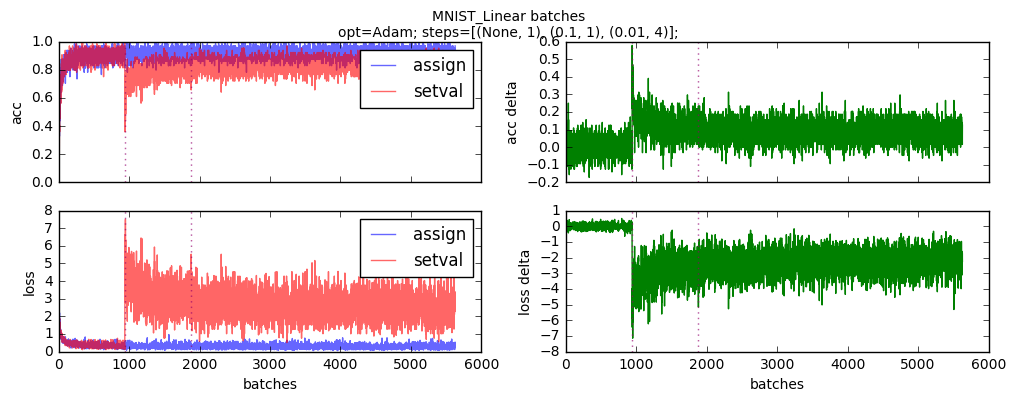

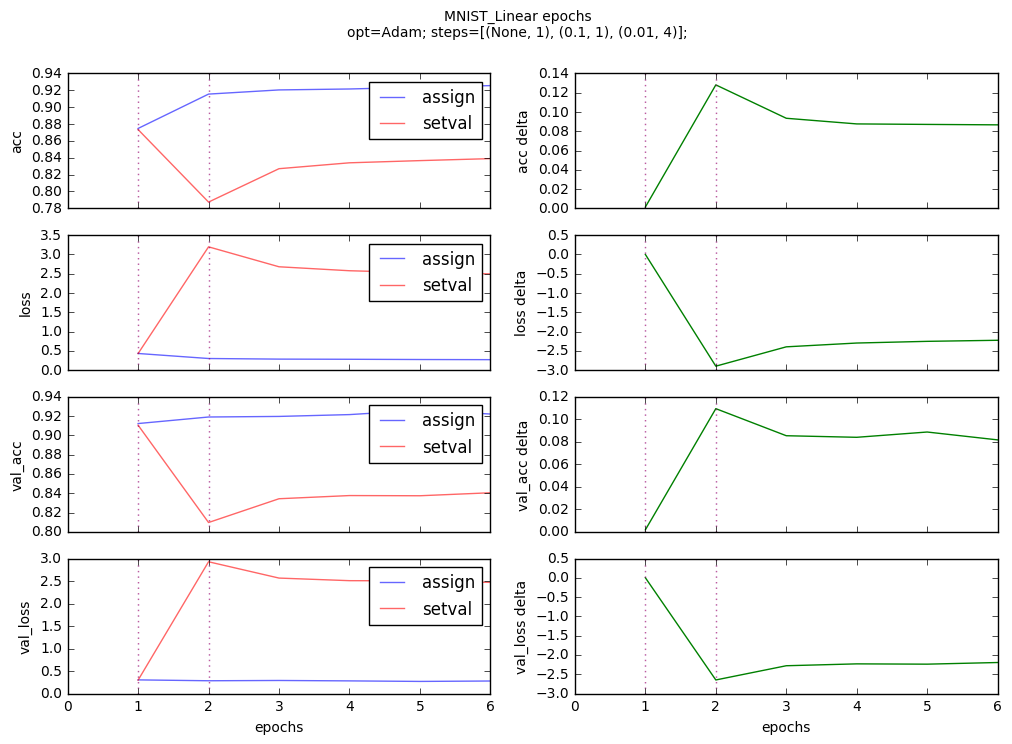

In [57]:
LRTester(MNIST_Linear, shuffle=True).run(steps=[None, 0.1, (0.01, 4)]).makefigs()

### GPU Results: MNIST CNN with batchnorm + dropout + data augmentation

Epoch 1/1
60000/60000 [==============================] - 49s - loss: 0.2172 - acc: 0.9339 - val_loss: 0.0659 - val_acc: 0.9778
Epoch 1/4
60000/60000 [==============================] - 51s - loss: 0.0917 - acc: 0.9714 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 2/4
60000/60000 [==============================] - 50s - loss: 0.0748 - acc: 0.9770 - val_loss: 0.0496 - val_acc: 0.9834
Epoch 3/4
60000/60000 [==============================] - 50s - loss: 0.0657 - acc: 0.9796 - val_loss: 0.0389 - val_acc: 0.9875
Epoch 4/4
60000/60000 [==============================] - 50s - loss: 0.0618 - acc: 0.9807 - val_loss: 0.0532 - val_acc: 0.9831
Epoch 1/12
60000/60000 [==============================] - 49s - loss: 0.0583 - acc: 0.9820 - val_loss: 0.0353 - val_acc: 0.9895
Epoch 2/12
60000/60000 [==============================] - 49s - loss: 0.0537 - acc: 0.9834 - val_loss: 0.0290 - val_acc: 0.9912
Epoch 3/12
60000/60000 [==============================] - 49s - loss: 0.0520 - acc: 0.9841 - val_loss: 0.0357

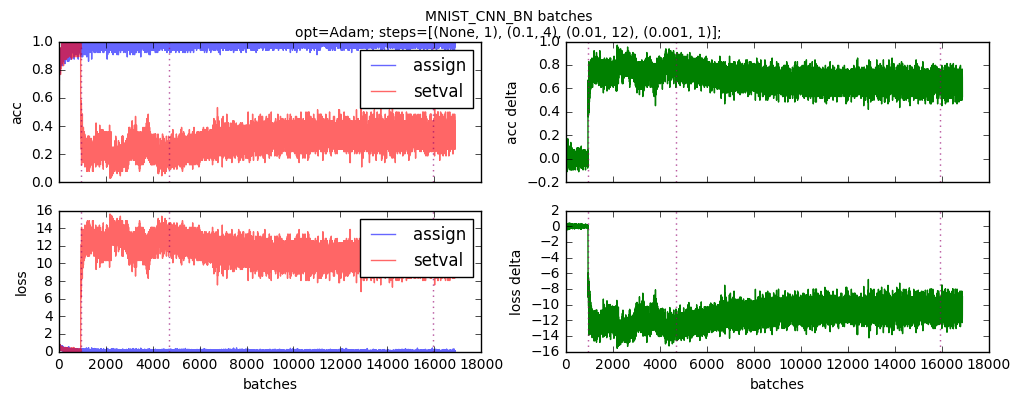

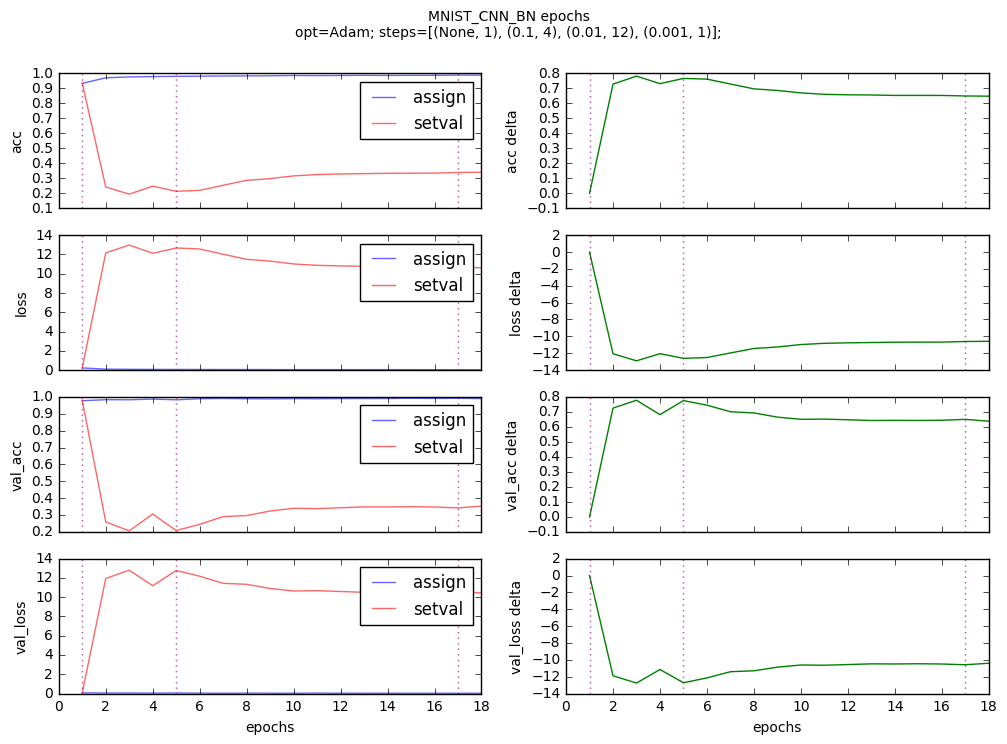

In [58]:
LRTester(MNIST_CNN_BN, shuffle=True).run(steps=[None, (0.1, 4), (0.01, 12), 0.001]).makefigs()

### GPU Results: MNIST CNN with batchnorm, no dropout, no data augmentation

Epoch 1/1
60000/60000 [==============================] - 49s - loss: 0.0903 - acc: 0.9728 - val_loss: 0.0509 - val_acc: 0.9835
Epoch 1/4
60000/60000 [==============================] - 49s - loss: 0.0313 - acc: 0.9906 - val_loss: 0.0355 - val_acc: 0.9885
Epoch 2/4
60000/60000 [==============================] - 50s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.0431 - val_acc: 0.9861
Epoch 3/4
60000/60000 [==============================] - 50s - loss: 0.0170 - acc: 0.9945 - val_loss: 0.0505 - val_acc: 0.9856
Epoch 4/4
60000/60000 [==============================] - 49s - loss: 0.0154 - acc: 0.9949 - val_loss: 0.0497 - val_acc: 0.9868
Epoch 1/1
60000/60000 [==============================] - 50s - loss: 0.0105 - acc: 0.9965 - val_loss: 0.0435 - val_acc: 0.9888
Epoch 1/1
60000/60000 [==============================] - 49s - loss: 0.0101 - acc: 0.9965 - val_loss: 0.0340 - val_acc: 0.9922
Epoch 1/1
60000/60000 [==============================] - 49s - loss: 0.0908 - acc: 0.9728 - val_loss: 0.0618 - 

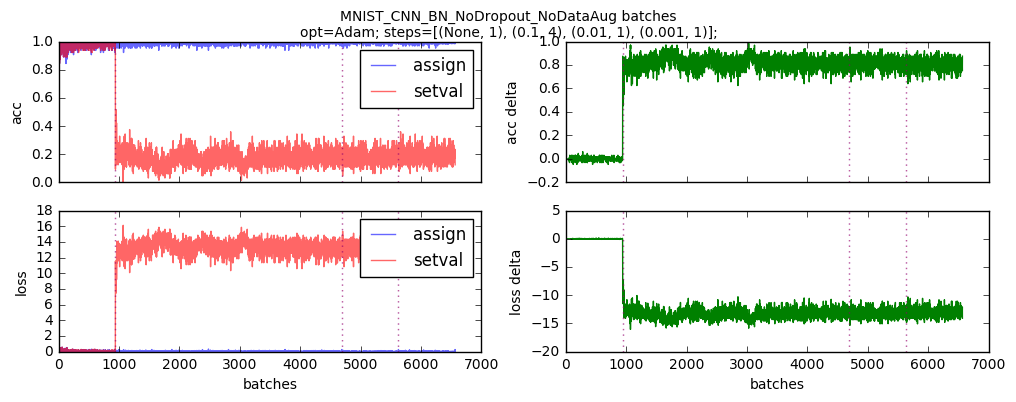

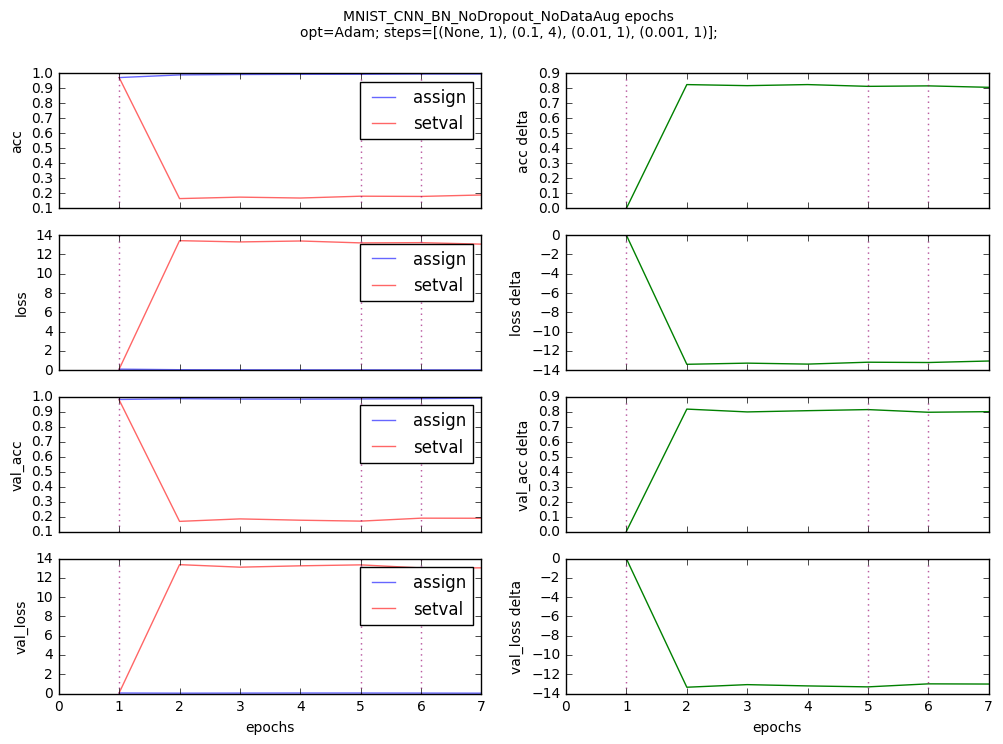

In [59]:
LRTester(MNIST_CNN_BN_NoDropout_NoDataAug, shuffle=False).run(steps=[None, (0.1, 4), 0.01, 0.001]).makefigs()

### GPU Results: DogsCats Vgg16

The `DogsCats_Vgg16` model is explored multiple times across lessons 1-3 and the `dogs_cats_redux` notebook. Just go with a "standard" learning rate progression of `steps=[None, 0.1, 0.001]`.

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 657s - loss: 0.1276 - acc: 0.9673 - val_loss: 0.0630 - val_acc: 0.9790
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 659s - loss: 0.0859 - acc: 0.9786 - val_loss: 0.0635 - val_acc: 0.9835
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 659s - loss: 0.1028 - acc: 0.9780 - val_loss: 0.0660 - val_acc: 0.9840
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 659s - loss: 0.1213 - acc: 0.9677 - val_loss: 0.0

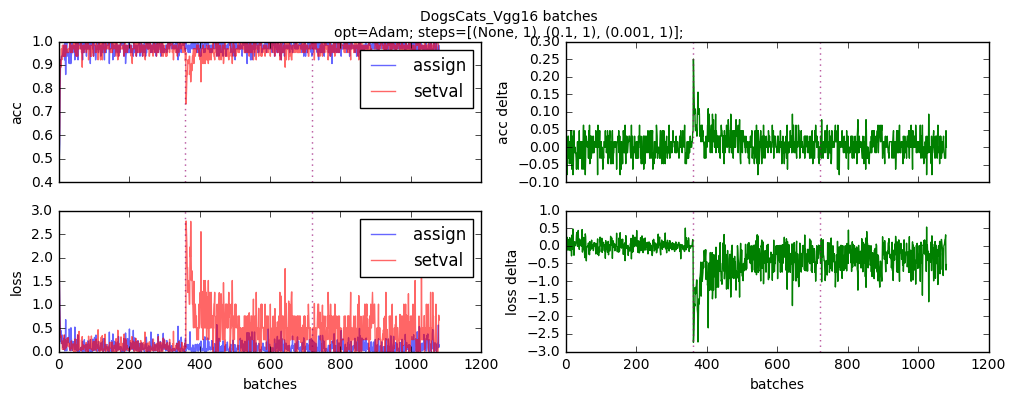

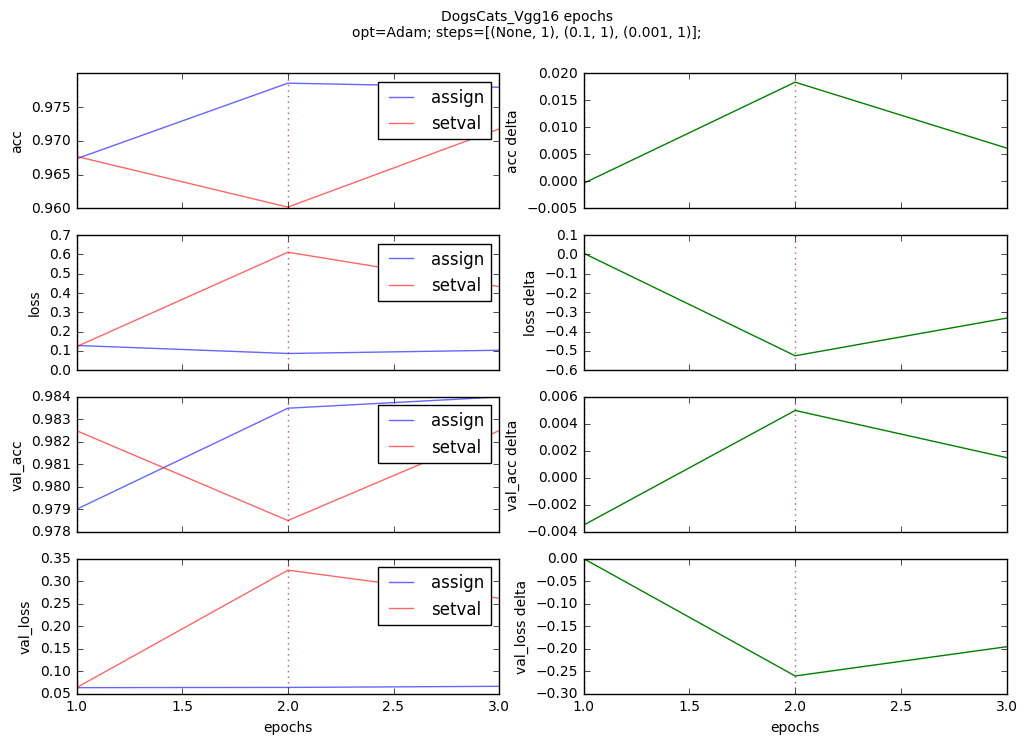

In [60]:
LRTester(DogsCats_Vgg16, shuffle=True).run(steps=[None, 0.1, 0.001]).makefigs()

### GPU Results: DogsCats Vgg16 No Dropout

In the lesson 3 notebook, the DogsCats model without dropout is run for 8 epochs without ever changing the learning rate. Therefore, add a single learning rate change after the 8 initial epochs, to make the test more interesting.

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 34s - loss: 0.1905 - acc: 0.9630 - val_loss: 4.8697 - val_acc: 0.5235
Epoch 2/8
23000/23000 [==============================] - 35s - loss: 0.0965 - acc: 0.9871 - val_loss: 4.2888 - val_acc: 0.5620
Epoch 3/8
23000/23000 [==============================] - 35s - loss: 0.0701 - acc: 0.9920 - val_loss: 5.0726 - val_acc: 0.5430
Epoch 4/8
23000/23000 [==============================] - 35s - loss: 0.0723 - acc: 0.9931 - val_loss: 5.5820 - val_acc: 0.5305
Epoch 5/8
23000/23000 [==============================] - 35s - loss: 0.0795 - acc: 0.9929 - val_loss: 5.0078 - val_acc: 0.5510
Epoch 6/8
23000/23000 [==============================] - 35s - loss: 0.0731 - acc: 0.9933 - val_loss: 4.2402 - val_acc: 0.5815
Epoch 7/8
23000/23000 [==============================] - 35s - loss: 0.0621 - acc: 0.9942 - val_loss: 4.1897 - val_acc: 0.5860
Epoch 8/8
23000/23000 [==============================] - 35s -

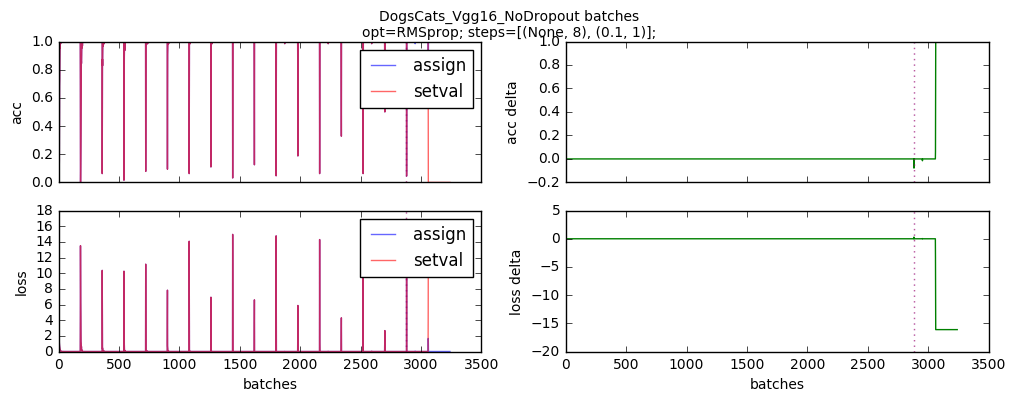

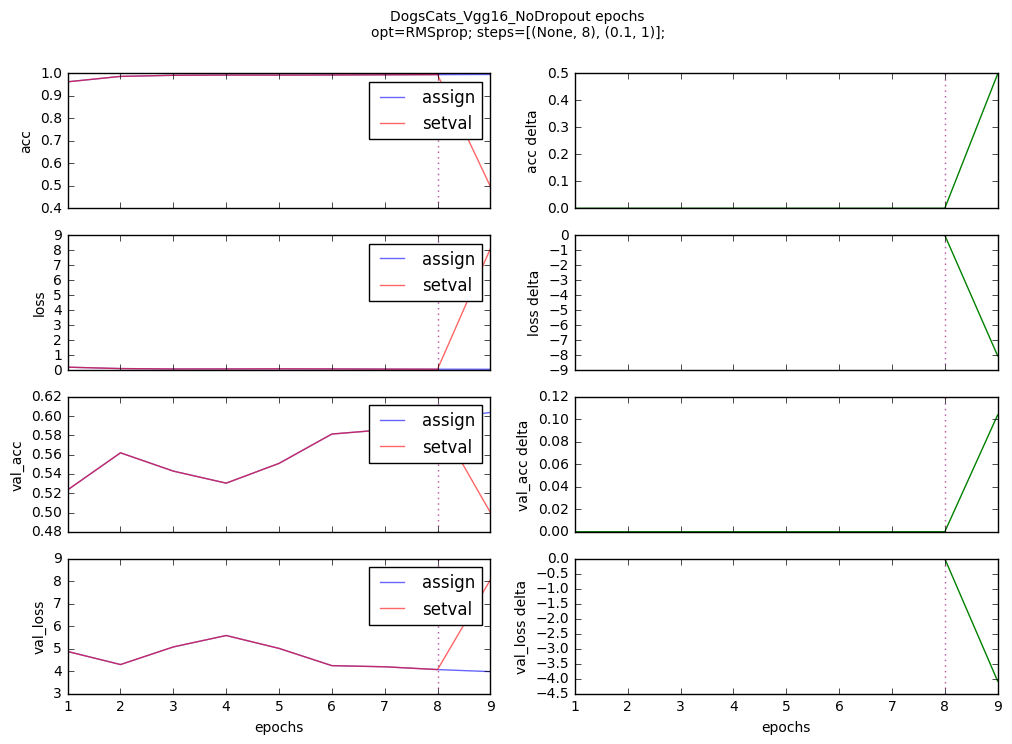

In [61]:
LRTester(DogsCats_Vgg16_NoDropout, shuffle=False).run(steps=[(None, 8), 0.1]).makefigs()

### GPU Results: IMDB Ratings NN

As with `DogsCats_Vgg16_NoDropout` above, add a single learning rate change after the 8 initial epochs, to make the test more interesting.

Train on 80184 samples, validate on 19820 samples
Epoch 1/8
80184/80184 [==============================] - 8s - loss: 2.2765 - acc: 0.2006 - val_loss: 0.8790 - val_acc: 0.2942
Epoch 2/8
80184/80184 [==============================] - 8s - loss: 1.3820 - acc: 0.2393 - val_loss: 0.8183 - val_acc: 0.3117
Epoch 3/8
80184/80184 [==============================] - 8s - loss: 1.1870 - acc: 0.2628 - val_loss: 0.8094 - val_acc: 0.3161
Epoch 4/8
80184/80184 [==============================] - 8s - loss: 1.0234 - acc: 0.2881 - val_loss: 0.8031 - val_acc: 0.3176
Epoch 5/8
80184/80184 [==============================] - 8s - loss: 0.9147 - acc: 0.3051 - val_loss: 0.7909 - val_acc: 0.3232
Epoch 6/8
80184/80184 [==============================] - 8s - loss: 0.8535 - acc: 0.3211 - val_loss: 0.7835 - val_acc: 0.3280
Epoch 7/8
80184/80184 [==============================] - 8s - loss: 0.8230 - acc: 0.3321 - val_loss: 0.7836 - val_acc: 0.3277
Epoch 8/8
80184/80184 [==============================] - 8s - loss: 

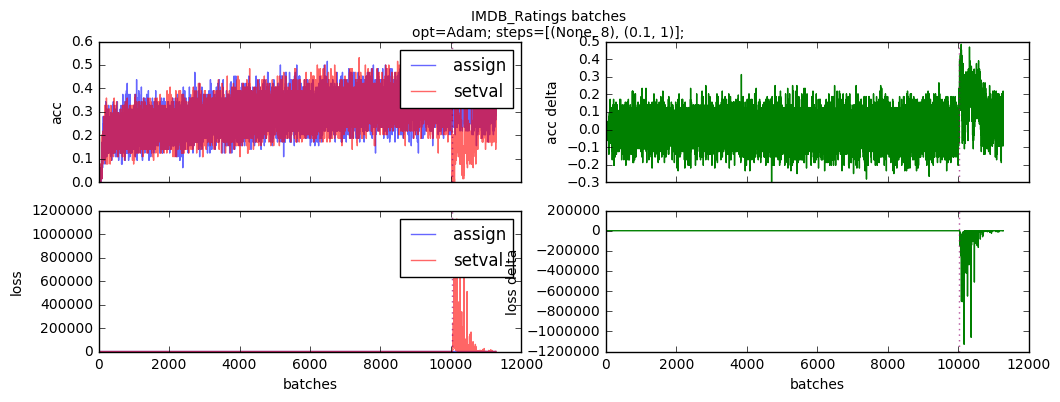

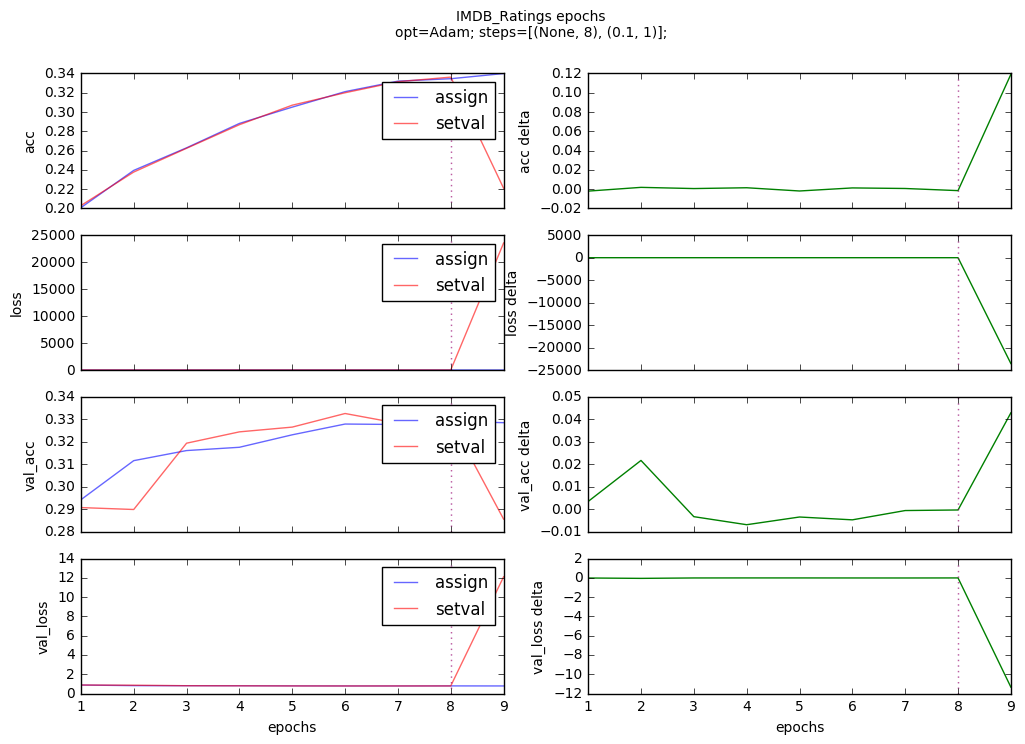

In [62]:
LRTester(IMDB_Ratings, shuffle=True).run(steps=[(None, 8), 0.1]).makefigs()

### GPU Results: IMDB Ratings NN (No Dropout)

Train on 80184 samples, validate on 19820 samples
Epoch 1/8
80184/80184 [==============================] - 8s - loss: 2.4235 - acc: 0.1942 - val_loss: 1.2282 - val_acc: 0.2784
Epoch 2/8
80184/80184 [==============================] - 8s - loss: 1.4614 - acc: 0.2341 - val_loss: 0.8669 - val_acc: 0.3100
Epoch 3/8
80184/80184 [==============================] - 8s - loss: 1.2539 - acc: 0.2583 - val_loss: 0.8740 - val_acc: 0.3027
Epoch 4/8
80184/80184 [==============================] - 8s - loss: 1.0924 - acc: 0.2764 - val_loss: 0.8665 - val_acc: 0.3024
Epoch 5/8
80184/80184 [==============================] - 8s - loss: 0.9892 - acc: 0.2926 - val_loss: 0.8520 - val_acc: 0.3066
Epoch 6/8
80184/80184 [==============================] - 8s - loss: 0.9114 - acc: 0.3084 - val_loss: 0.8356 - val_acc: 0.3117
Epoch 7/8
80184/80184 [==============================] - 8s - loss: 0.8636 - acc: 0.3178 - val_loss: 0.8379 - val_acc: 0.3130
Epoch 8/8
80184/80184 [==============================] - 8s - loss: 

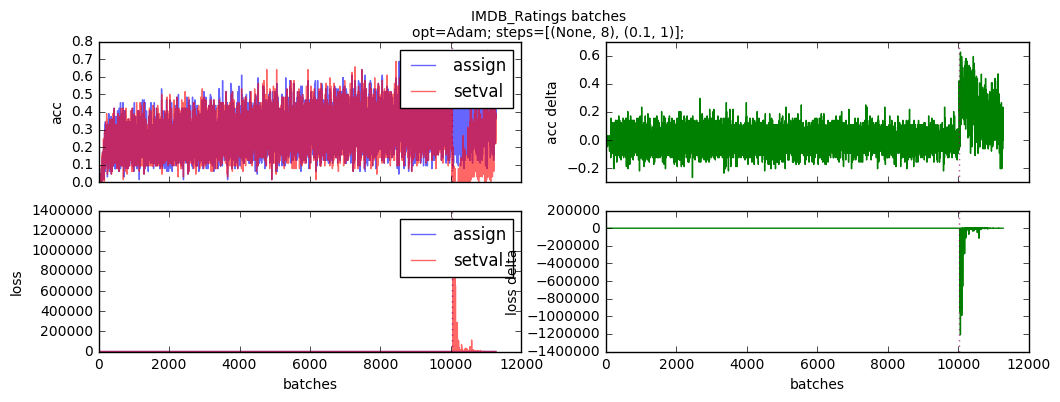

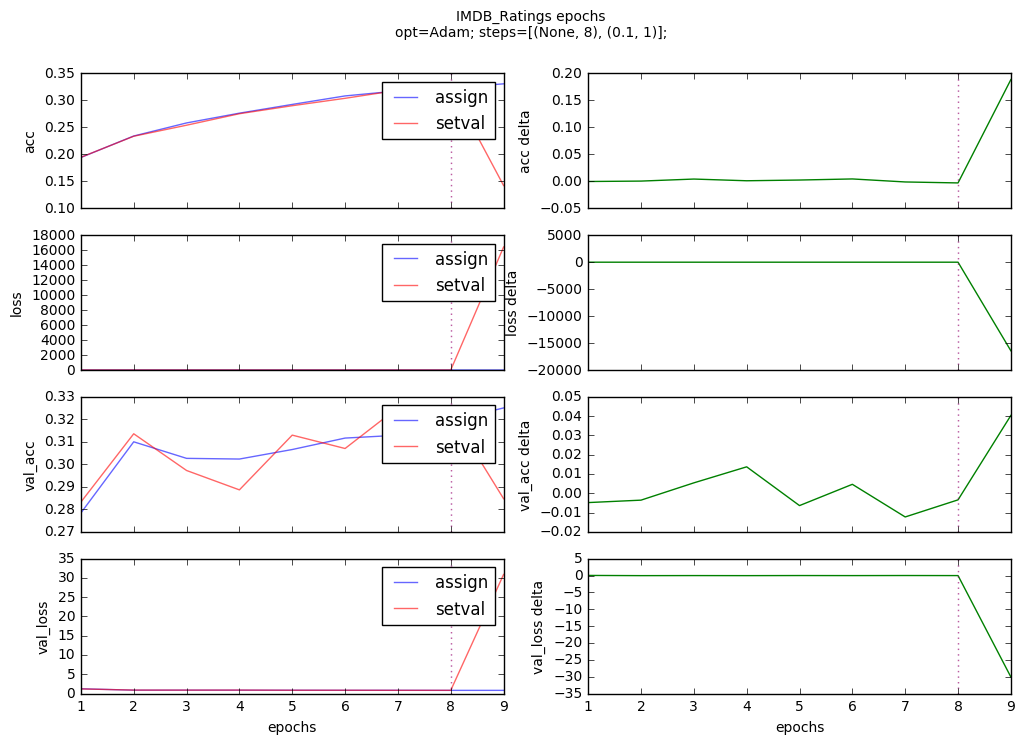

In [63]:
LRTester(IMDB_Ratings, shuffle=False).run(steps=[(None, 8), 0.1]).makefigs()

### GPU Results: IMDB Sentiment Analysis CNN

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.6199 - acc: 0.6454 - val_loss: 0.5063 - val_acc: 0.7658
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 0.5211 - acc: 0.7491 - val_loss: 0.4865 - val_acc: 0.7811
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 13s - loss: 0.4829 - acc: 0.7743 - val_loss: 0.4514 - val_acc: 0.8167
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.6238 - acc: 0.6354 - val_loss: 0.5124 - val_acc: 0.7721
Epoch 2/2
25000/25000 [==============================] - 12s - loss: 0.5114 - acc: 0.7525 - val_loss: 0.5132 - val_acc: 0.7552
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 12s - loss: 0.4762 - acc: 0.7789 - val_loss: 0.4564 - val_acc: 0.8044


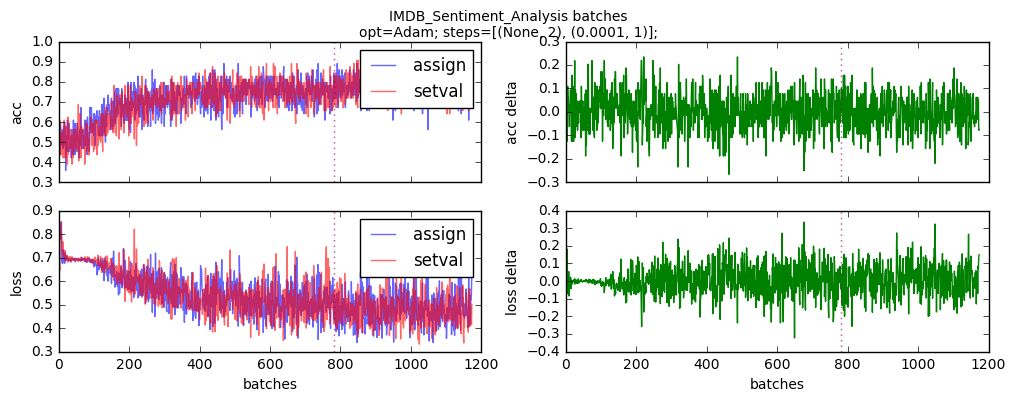

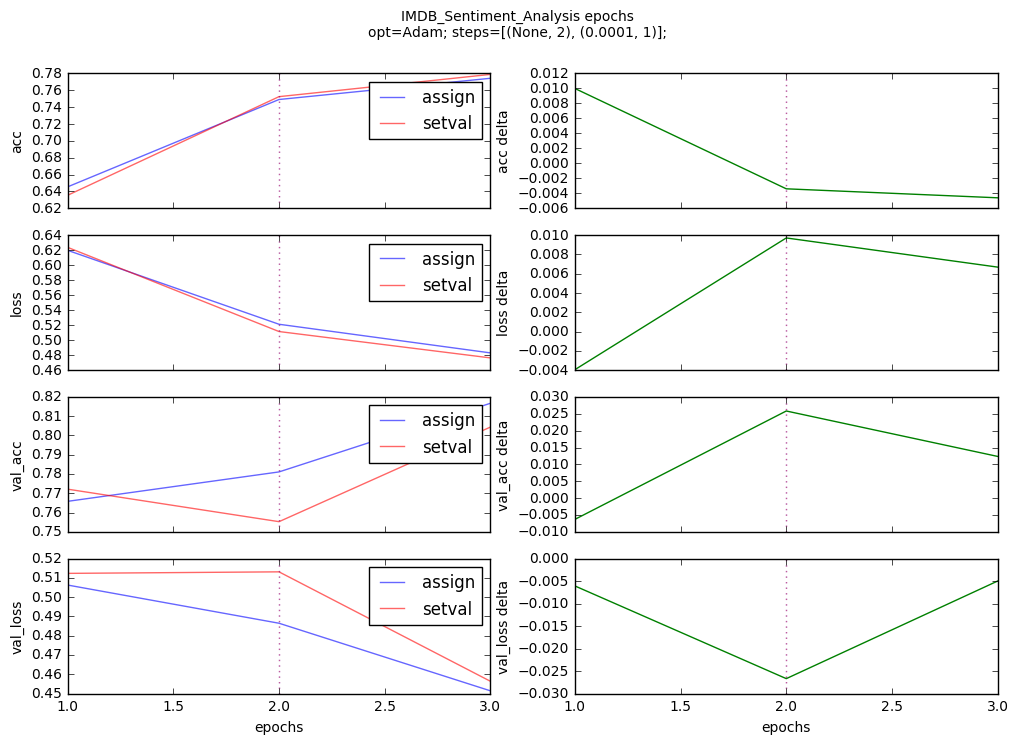

In [64]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=True)
t = LRTester(IMDB_Sentiment_Analysis, shuffle=True)
t.run(steps=[(None, 2), 1e-4], step_callback=step_callback)
t.makefigs()

### GPU Results: IMDB Sentiment Analysis CNN (No Dropout)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.4487 - acc: 0.9720 - val_loss: 7.8425 - val_acc: 0.5000
Epoch 2/2
25000/25000 [==============================] - 12s - loss: 1.3363 - acc: 0.5929 - val_loss: 4.7131 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 13s - loss: 1.0149 - acc: 0.8276 - val_loss: 4.1198 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 12s - loss: 0.4671 - acc: 0.9698 - val_loss: 7.8942 - val_acc: 0.5000
Epoch 2/2
25000/25000 [==============================] - 12s - loss: 1.1329 - acc: 0.4548 - val_loss: 0.7213 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 13s - loss: 0.7294 - acc: 0.4956 - val_loss: 0.7136 - val_acc: 0.5000


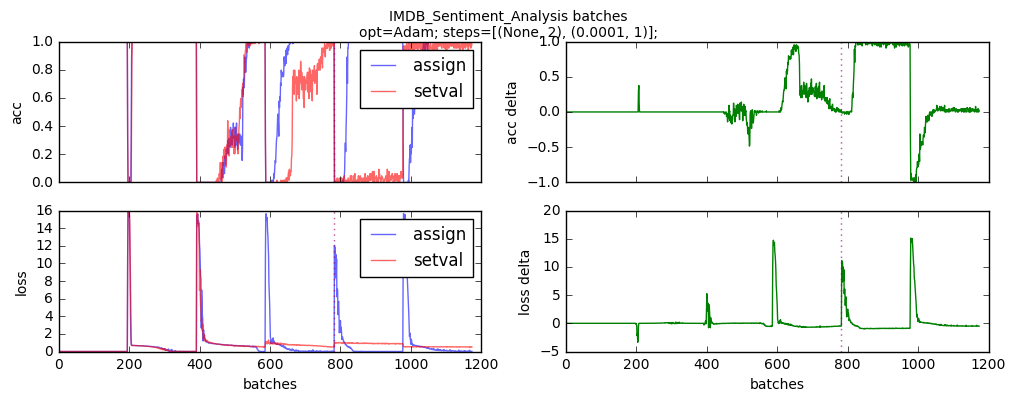

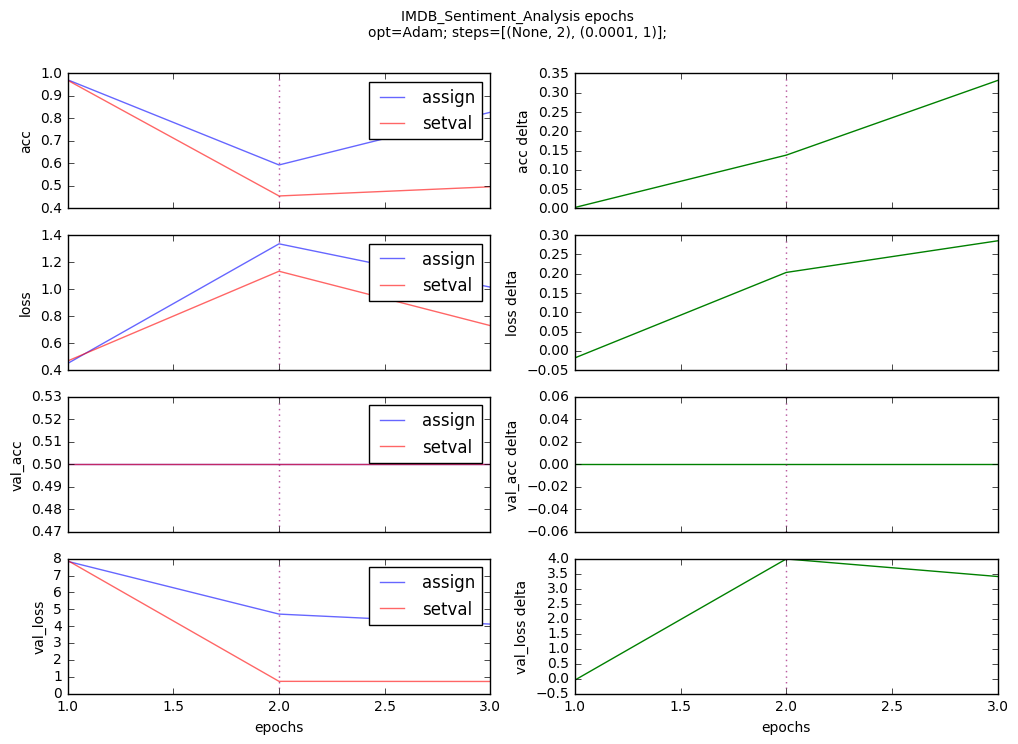

In [65]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=True)
t = LRTester(IMDB_Sentiment_Analysis, shuffle=False)
t.run(steps=[(None, 2), 1e-4], step_callback=step_callback)
t.makefigs()

### GPU Results: IMDB Sentiment Analysis Multi CNN

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.6249 - acc: 0.6378 - val_loss: 0.5310 - val_acc: 0.7630
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 0.5192 - acc: 0.7516 - val_loss: 0.4800 - val_acc: 0.7897
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.4868 - acc: 0.7755 - val_loss: 0.4444 - val_acc: 0.8094
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 0.4641 - acc: 0.7860 - val_loss: 0.4215 - val_acc: 0.8242
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.6085 - acc: 0.6579 - val_loss: 0.5324 - val_acc: 0.7556
Epoch 2/2
25000/25000 [==============================] - 12s - loss: 0.5002 - acc: 0.7617 - val_loss: 0.4573 - val_acc: 0.8118
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [===============

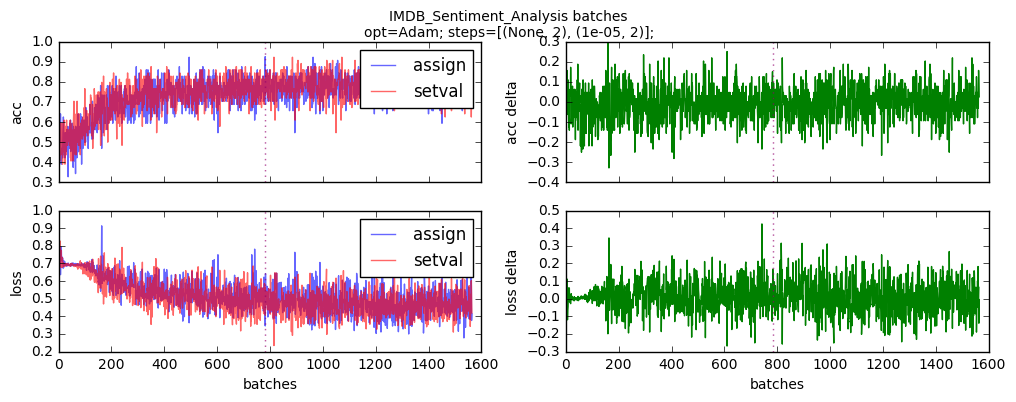

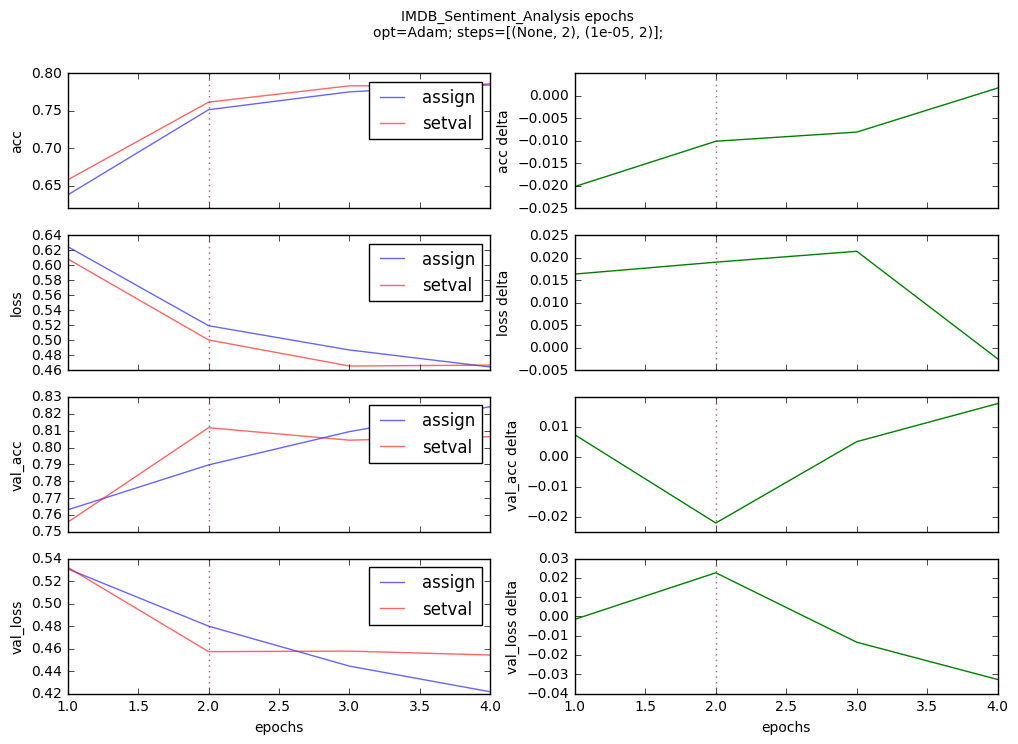

In [66]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=False)
t = LRTester(IMDB_Sentiment_Analysis, shuffle=True)
t.run(steps=[(None, 2), (1e-5, 2)], step_callback=step_callback)
t.makefigs()

### GPU Results: IMDB Sentiment Analysis Multi CNN (No Dropout)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.4776 - acc: 0.9695 - val_loss: 7.5960 - val_acc: 0.5000
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 1.2098 - acc: 0.6256 - val_loss: 4.5556 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.8978 - acc: 0.7494 - val_loss: 8.0152 - val_acc: 0.5000
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 1.1293 - acc: 0.6426 - val_loss: 8.0324 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.4805 - acc: 0.9708 - val_loss: 7.4484 - val_acc: 0.5000
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 1.1823 - acc: 0.5972 - val_loss: 3.9864 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [===============

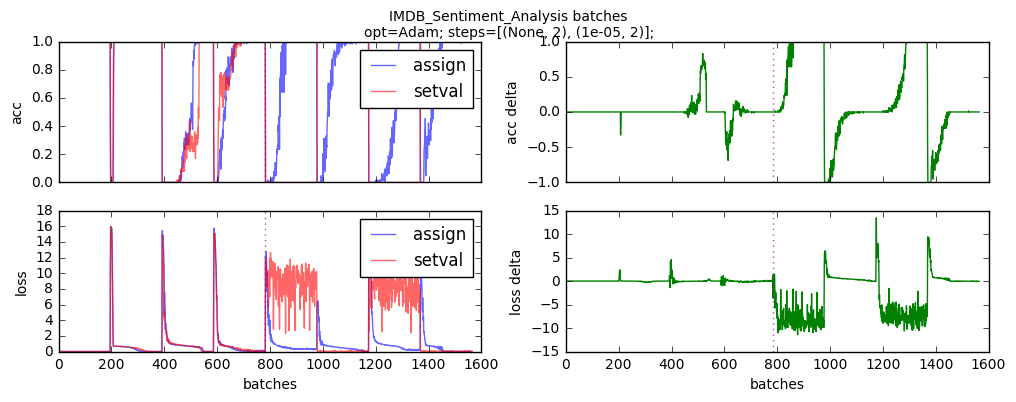

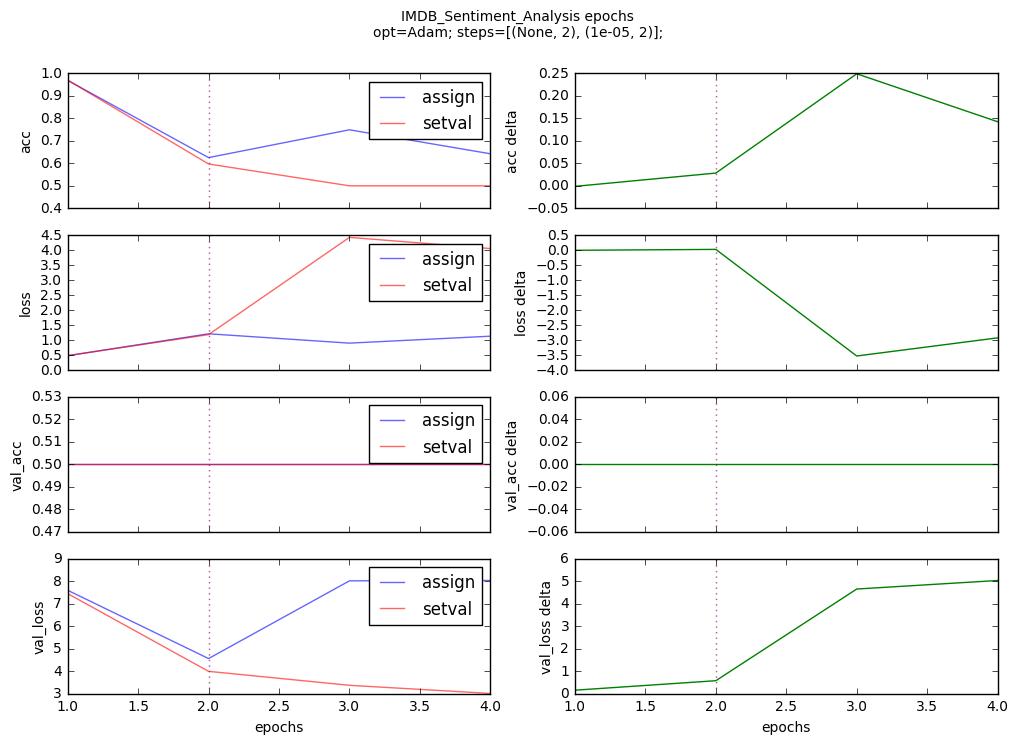

In [67]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=False)
t = LRTester(IMDB_Sentiment_Analysis, shuffle=False)
t.run(steps=[(None, 2), (1e-5, 2)], step_callback=step_callback)
t.makefigs()

### GPU Results: Nietzsche 3-char model

Epoch 1/4
200297/200297 [==============================] - 17s - loss: 4.4174 - acc: 0.0926    
Epoch 2/4
200297/200297 [==============================] - 17s - loss: 4.2917 - acc: 0.1617    
Epoch 3/4
200297/200297 [==============================] - 17s - loss: 4.0171 - acc: 0.1554    
Epoch 4/4
200297/200297 [==============================] - 17s - loss: 3.6123 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 17s - loss: 3.3186 - acc: 0.1524    
Epoch 2/4
200297/200297 [==============================] - 17s - loss: 3.1988 - acc: 0.1524    
Epoch 3/4
200297/200297 [==============================] - 17s - loss: 3.1483 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 17s - loss: 3.1227 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 17s - loss: 3.1060 - acc: 0.1524    
Epoch 2/4
200297/200297 [==============================] - 17s - loss: 3.0936 - acc: 0.1524    
Epoch 3/4
200297/200297 [===============

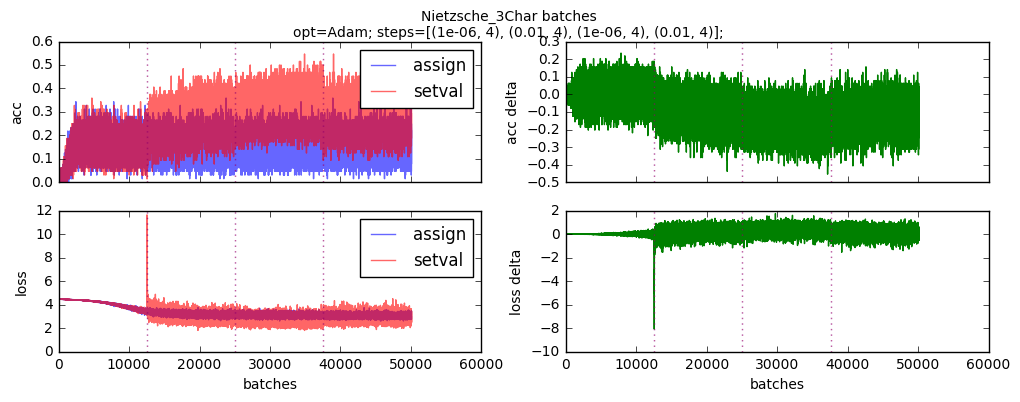

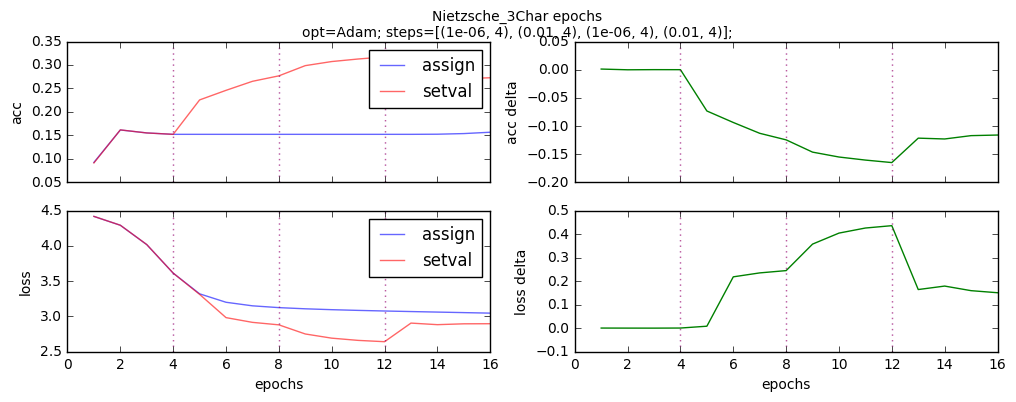

In [68]:
LRTester(Nietzsche_3Char, shuffle=True).run(steps=[(0.000001, 4), (0.01, 4), (0.000001, 4), (0.01, 4)]).makefigs()

### GPU Results: Nietzsche RNN returing sequences

As with `DogsCats_Vgg16_NoDropout` and `IMDB_Ratings`, above, add a single learning rate change after the 8 initial epochs, to make the test more interesting.

Epoch 1/8
75110/75110 [==============================] - 15s - loss: 2.4405 - acc: 0.3144    
Epoch 2/8
75110/75110 [==============================] - 15s - loss: 2.0035 - acc: 0.4134    
Epoch 3/8
75110/75110 [==============================] - 15s - loss: 1.8886 - acc: 0.4423    
Epoch 4/8
75110/75110 [==============================] - 15s - loss: 1.8263 - acc: 0.4573    
Epoch 5/8
75110/75110 [==============================] - 15s - loss: 1.7875 - acc: 0.4666    
Epoch 6/8
75110/75110 [==============================] - 15s - loss: 1.7606 - acc: 0.4731    
Epoch 7/8
75110/75110 [==============================] - 15s - loss: 1.7394 - acc: 0.4785    
Epoch 8/8
75110/75110 [==============================] - 15s - loss: 1.7236 - acc: 0.4819    
Epoch 1/1
75110/75110 [==============================] - 15s - loss: 1.7103 - acc: 0.4856    
Epoch 1/8
75110/75110 [==============================] - 14s - loss: 2.4306 - acc: 0.3167    
Epoch 2/8
75110/75110 [==============================] - 14s

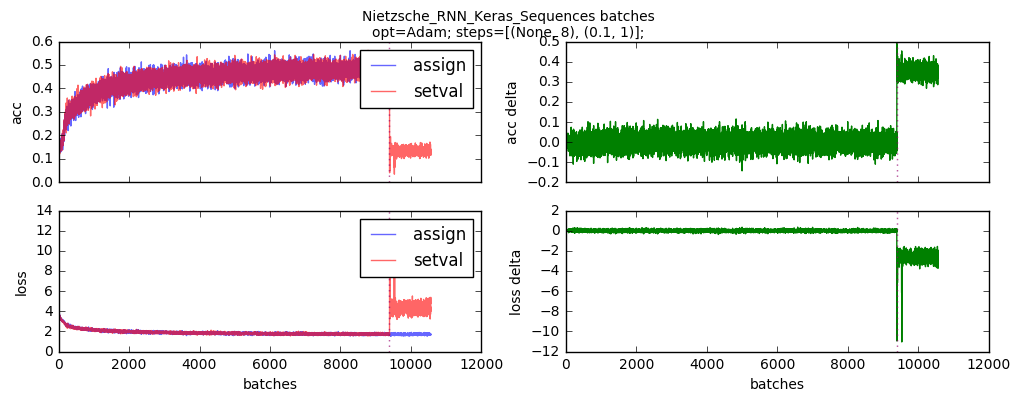

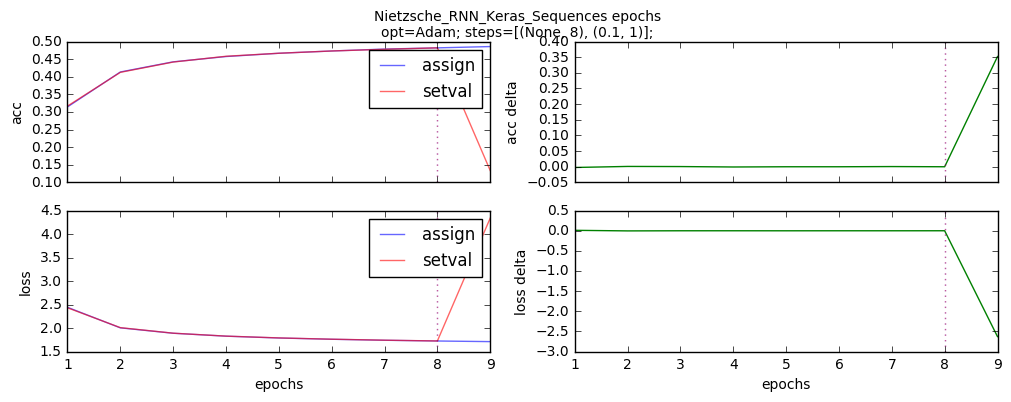

In [69]:
LRTester(Nietzsche_RNN_Keras_Sequences, shuffle=True).run(steps=[(None, 8), 0.1]).makefigs()

## GPU Results: go crazy

The test resutls in this "go crazy" section correspond to two calls to the `gocrazy` function, each of which tests a combinatorial cross-product of it's arguments:

    Models x Setters x Optimizers x Steps1 x Steps2

The first call to `gocrazy` looks at a small subset of models, and asks the question: how do the models behave when both use assignment (`BothAssign`) or both use `set_value` (`BothSetVal`), but the learning rates for the two models are stepped differently? That is, when `steps1 != steps2`. Specifically:

    Models = [DogsCatgs_Vgg16_NoDropout, IMDB_Ratings_NoDropout, Nietzsche_3Char]
    Setters = [BothAssign, BothSetVal]
    Opitimizers = [Adam, SGD]
    Steps1 = [[0.001, 0.1,   0.01],  [0.1,  0.001, 0.01]]
    Steps2 = [[0.001, 0.001, 0.001], [0.01, 0.001, 0.1]]
    
Resulting in $3 \times 2 \times 2 \times 2 \times 2 = 48$ calls to `LRTester.run`, each of which calls `fitmodel` $3 \times 2 = 6$ times, or $48 \times 6 = 288$ total calls to `fitmodel`.

In the second call to `gocrazy`, we do a more exhaustive test for a single model:

    Models = [IMDB_Sentiment_Analysis_NoDropout]
    Setters = [AssignAndSetVal, BothAssign, BothSetVal]
    Opitimizers = [Adam, SGD, RMSprop]
    Steps1 = permutations([0.1, 0.001, 0.00001])
    Steps2 = permutations([0.1, 0.001, 0.00001])

Resulting in $1 \times 3 \times 3 \times 3! \times 3! = 324$ calls to `LRTester.run`, each making $3 \times 2 = 6$ calls to `fitmodel`, for a total of $324 \times 6 = 1944$ calls to `fitmodel`.

## CPU Results

This section contains results for whatever random tests I happened to run on my laptop CPU while I was testing things out. The **GPU Results** section above has more structured tests.

### CPU Results: MNIST Linear Model

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4368 - acc: 0.8711 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3115 - acc: 0.9114 - val_loss: 0.3076 - val_acc: 0.9097
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.2966 - acc: 0.9168 - val_loss: 0.3046 - val_acc: 0.9116
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4368 - acc: 0.8711 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 5.0220 - acc: 0.6768 - val_loss: 4.4106 - val_acc: 0.7194
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.2451 - acc: 0.7308 - val_loss: 4.0815 - val_acc: 0.7414


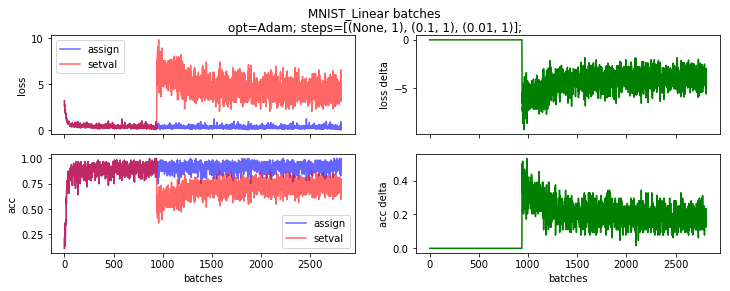

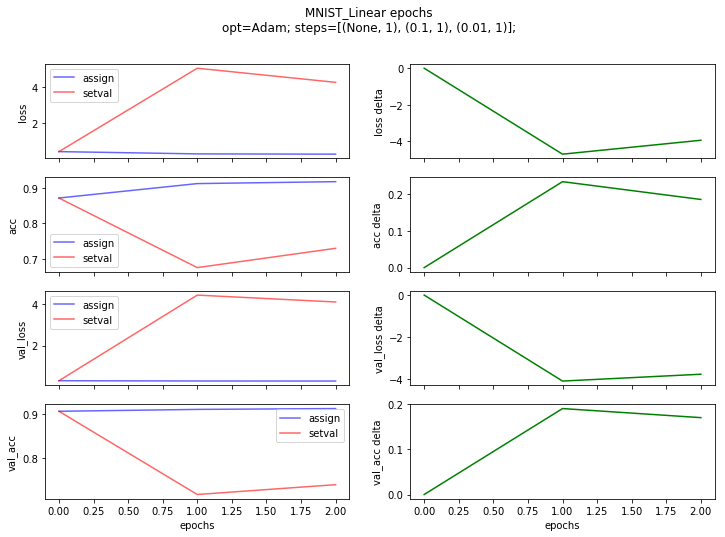

In [22]:
LRTester(MNIST_Linear).run(steps=[None, 0.1, 0.01]).makefigs()

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3100 - acc: 0.9122 - val_loss: 0.3082 - val_acc: 0.9111
Epoch 1/4
60000/60000 [==============================] - 24s - loss: 0.2959 - acc: 0.9172 - val_loss: 0.3052 - val_acc: 0.9124
Epoch 2/4
60000/60000 [==============================] - 24s - loss: 0.2884 - acc: 0.9197 - val_loss: 0.3041 - val_acc: 0.9136
Epoch 3/4
60000/60000 [==============================] - 24s - loss: 0.2833 - acc: 0.9212 - val_loss: 0.3033 - val_acc: 0.9138
Epoch 4/4
60000/60000 [==============================] - 30s - loss: 0.2796 - acc: 0.9226 - val_loss: 0.3031 - val_acc: 0.9147
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 6.8714 - acc: 0.5677 - val_loss: 6.5073 - 

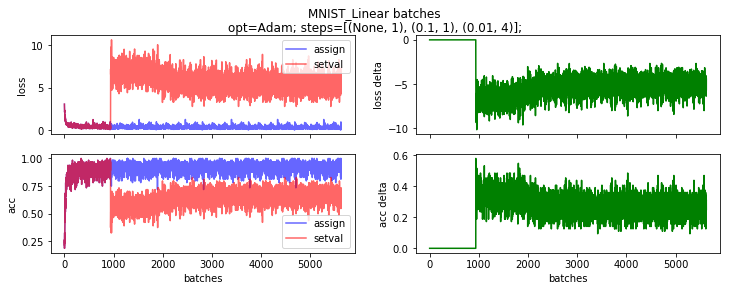

In [455]:
t = LRTester(MNIST_Linear, setter=AssignAndSetVal, optimizer=Adam)
t.run(steps=[(None, 1), (0.1, 1), (0.01, 4)])
t.makefig('batches')

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4305 - acc: 0.8727 - val_loss: 0.3216 - val_acc: 0.9039
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.3099 - acc: 0.9116 - val_loss: 0.3102 - val_acc: 0.9097
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 0.4305 - acc: 0.8727 - val_loss: 0.3216 - val_acc: 0.9039
Epoch 1/1
60000/60000 [==============================] - 27s - loss: 0.3099 - acc: 0.9116 - val_loss: 0.3102 - val_acc: 0.9097


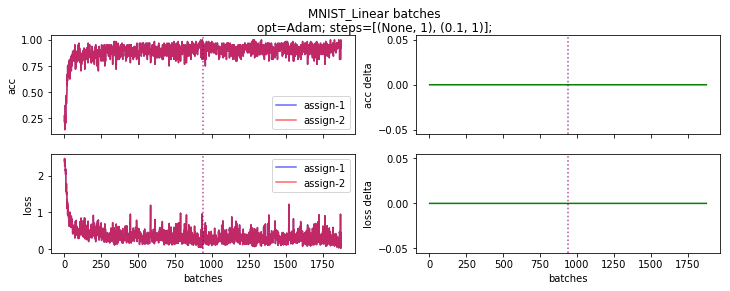

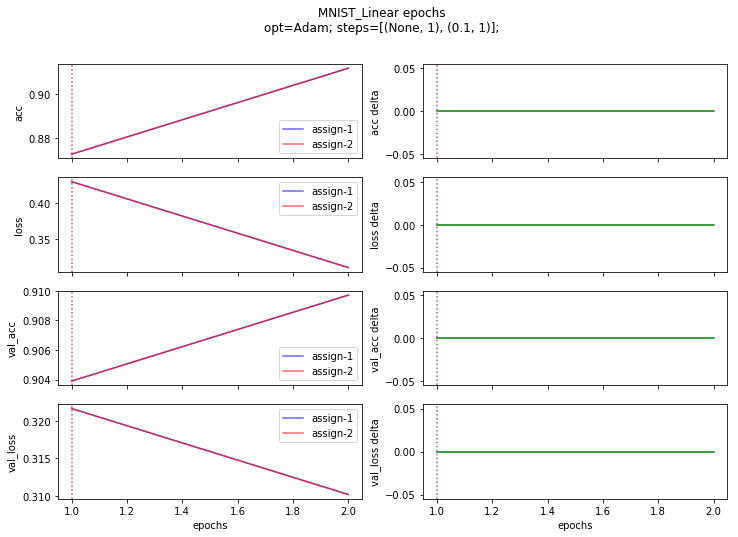

In [71]:
LRTester(MNIST_Linear, setter=BothAssign).run(steps=[None, 0.1]).makefigs()

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3110 - acc: 0.9113 - val_loss: 0.3083 - val_acc: 0.9110
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.2966 - acc: 0.9167 - val_loss: 0.3055 - val_acc: 0.9129
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.7737 - acc: 0.6910 - val_loss: 4.6670 - val_acc: 0.7028
Epoch 1/1
60000/60000 [==============================] - 34s - loss: 4.2944 - acc: 0.7280 - val_loss: 4.1933 - val_acc: 0.7346


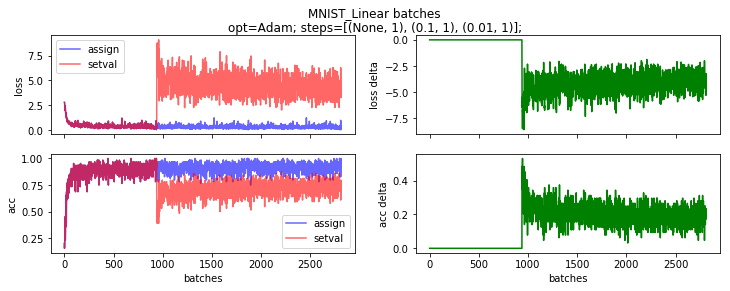

Epoch 1/1
60000/60000 [==============================] - 31s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 33s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698
Epoch 1/1
60000/60000 [==============================] - 29s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 22s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606.63 - ETA: 1s - l - ETA: 0s - loss: 5.7354 -  - ETA: 0s - los
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698


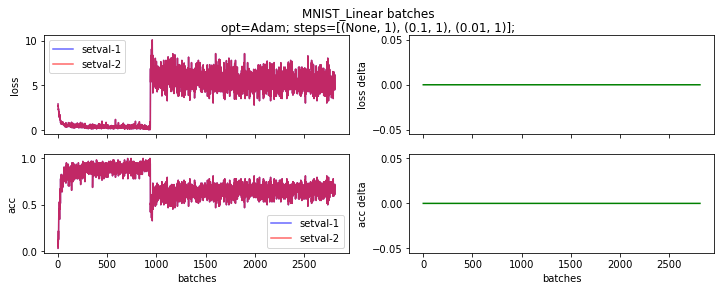

Epoch 1/1
60000/60000 [==============================] - 34s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115


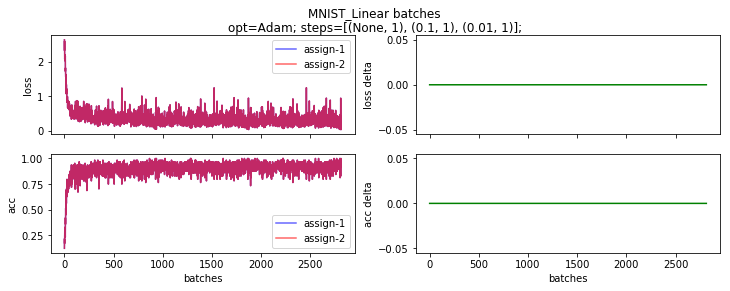

Epoch 1/1
60000/60000 [==============================] - 41s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.90110.5072 - acc: 0.85
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.3425 - acc: 0.9017 - val_loss: 0.3132 - val_acc: 0.9102
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3184 - acc: 0.9088 - val_loss: 0.3004 - val_acc: 0.9135
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.9011
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.3429 - acc: 0.9024 - val_loss: 0.3415 - val_acc: 0.9010
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.2857 - acc: 0.9208 - val_loss: 0.2807 - val_acc: 0.9207


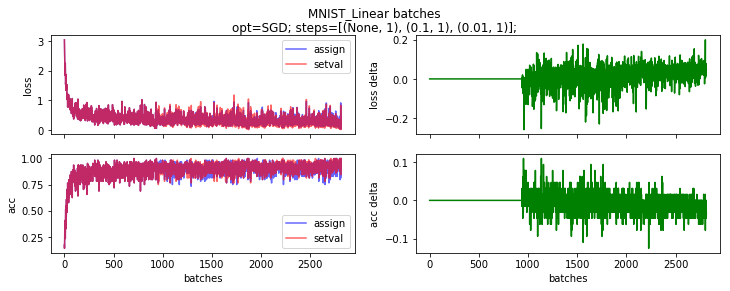

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200.920 - ETA: 0s - loss: 0.
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200


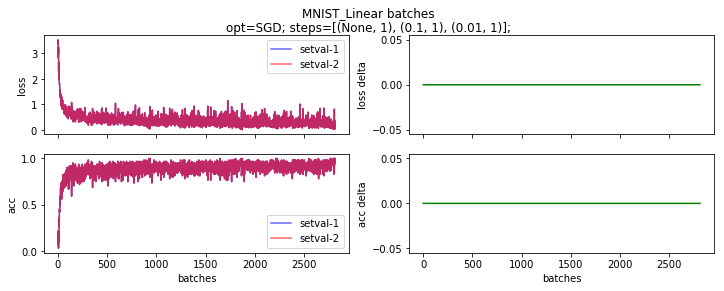

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120


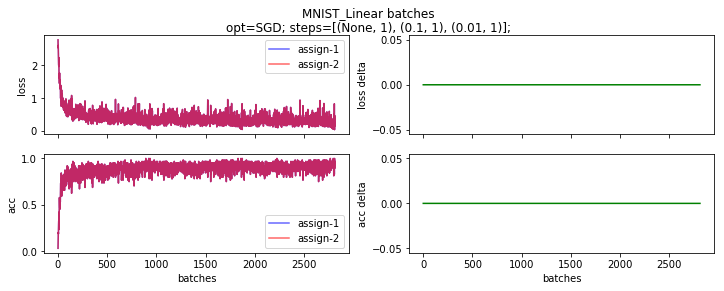

In [458]:
runtests(MNIST_Linear)

### CPU Results: MNIST CNN with batchnorm + dropout + data augmentation

/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


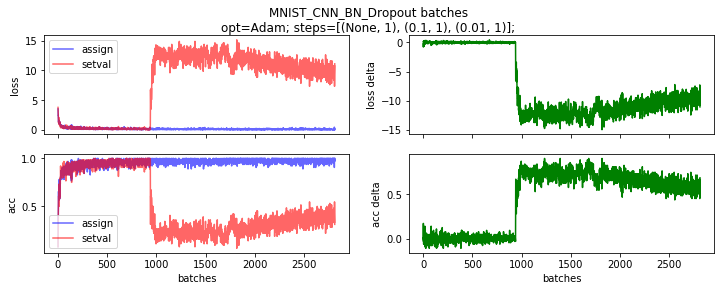

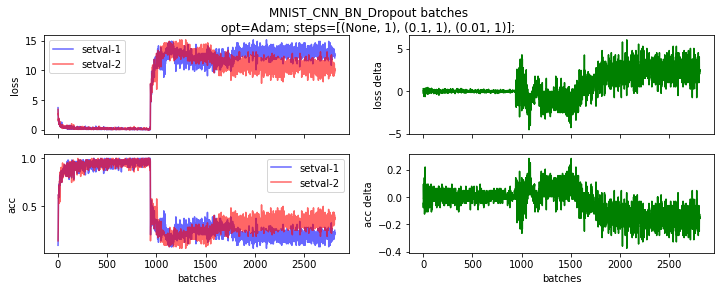

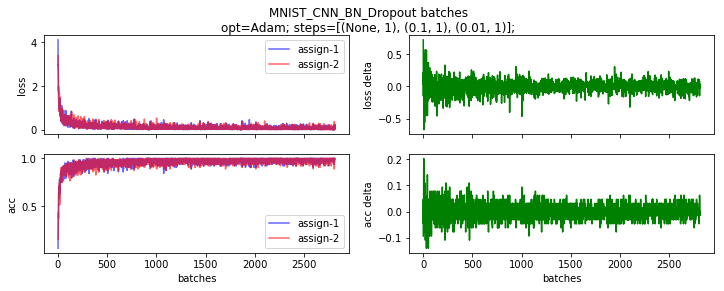

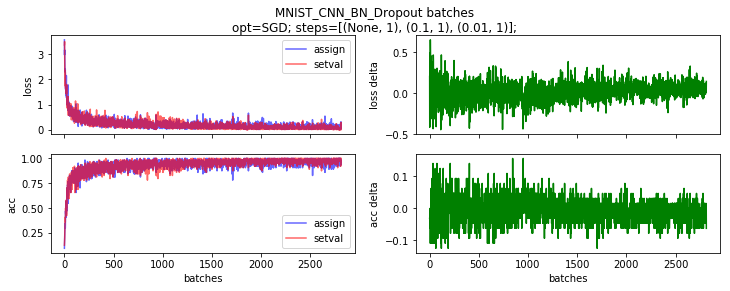

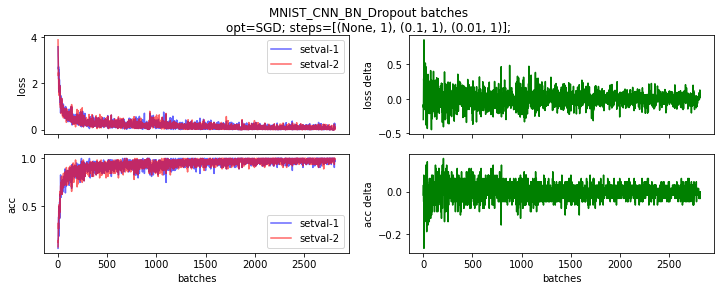

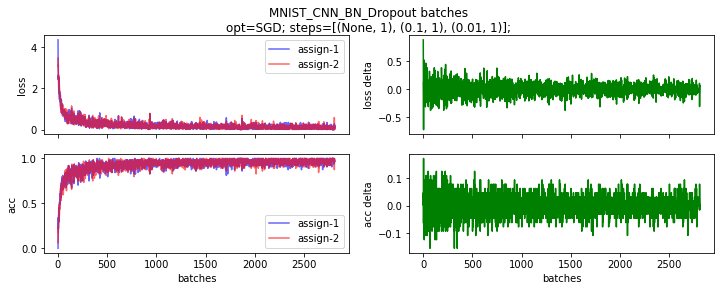

In [464]:
runtests(MNIST_CNN_BN)

### CPU Results: MNIST CNN with batchnorm, no dropout, no data augmentation

Epoch 1/1
60000/60000 [==============================] - 520s - loss: 0.0883 - acc: 0.9736 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 1/1
60000/60000 [==============================] - 603s - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0365 - val_acc: 0.9892
Epoch 1/1
60000/60000 [==============================] - 623s - loss: 0.0883 - acc: 0.9736 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 1/1
60000/60000 [==============================] - 621s - loss: 11.1748 - acc: 0.3048 - val_loss: 10.9154 - val_acc: 0.3224


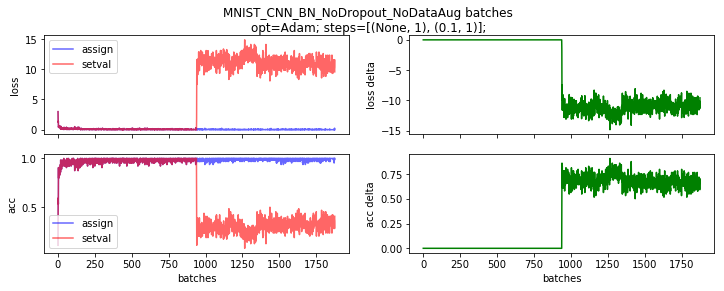

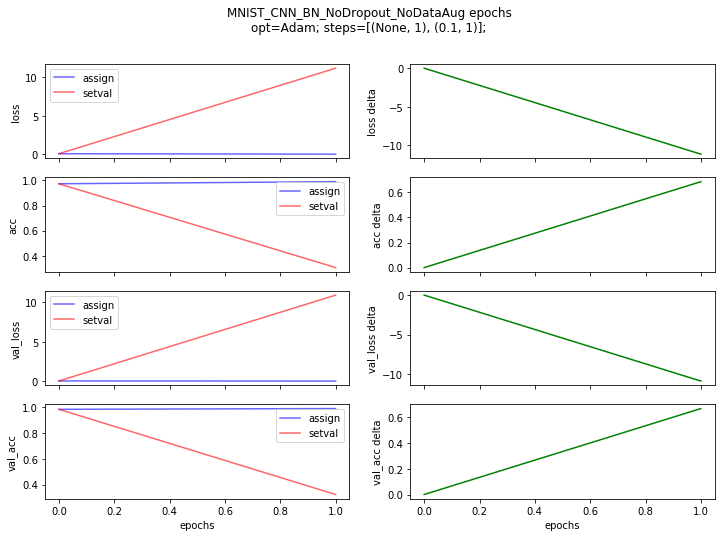

In [40]:
LRTester(MNIST_CNN_BN_NoDropout_NoDataAug).run([None, 0.1]).makefigs()

### CPU Results: DogsCats Vgg16

### CPU Results: DogsCats Vgg16 No Dropout

### CPU Results: IMDB Ratings NN

Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 29s - loss: 2.5930 - acc: 0.1850 - val_loss: 1.2576 - val_acc: 0.2752
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 50s - loss: 1.5564 - acc: 0.2285 - val_loss: 0.8845 - val_acc: 0.3137
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 39s - loss: 1.2877 - acc: 0.2511 - val_loss: 0.8813 - val_acc: 0.2950
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 32s - loss: 2.6022 - acc: 0.1836 - val_loss: 1.2231 - val_acc: 0.2827
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 38s - loss: 6281.3644 - acc: 0.1915 - val_loss: 9091.3288 - val_acc: 0.2884
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 84

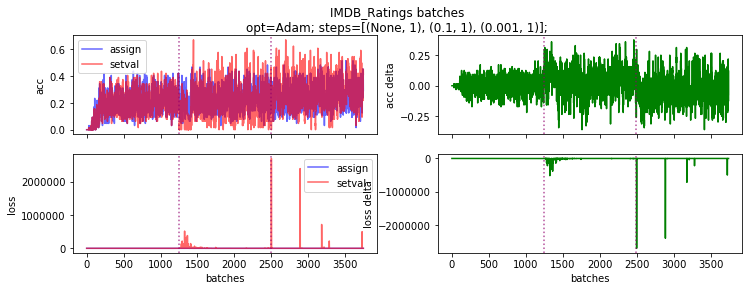

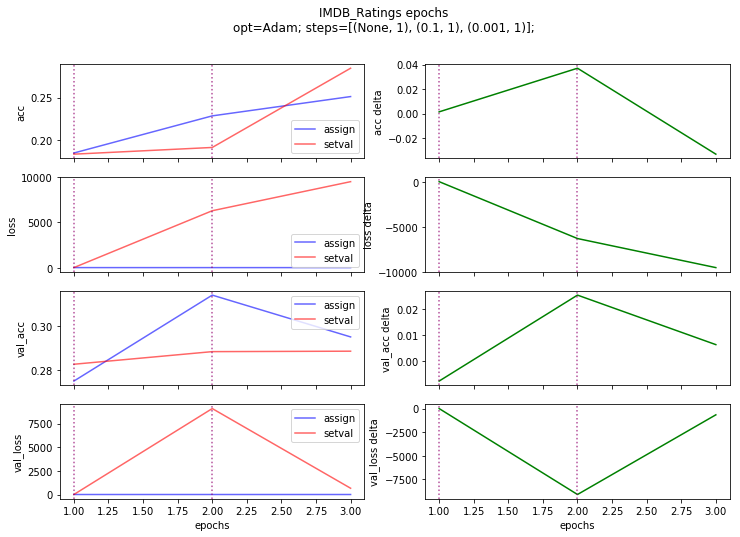

In [117]:
LRTester(IMDB_Ratings).run(steps=[None, 0.1, 0.001]).makefigs()

### CPU Results: IMDB Ratings NN (No Dropout)

Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 25s - loss: 1.7542 - acc: 0.2605 - val_loss: 1.3941 - val_acc: 0.2633
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 32s - loss: 0.8565 - acc: 0.3217 - val_loss: 1.0303 - val_acc: 0.3119
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 30s - loss: 0.7941 - acc: 0.3357 - val_loss: 0.9269 - val_acc: 0.3213
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 24s - loss: 1.7542 - acc: 0.2605 - val_loss: 1.3941 - val_acc: 0.2633
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 33s - loss: 8276.0268 - acc: 0.2387 - val_loss: 6709.8118 - val_acc: 0.2771
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 56

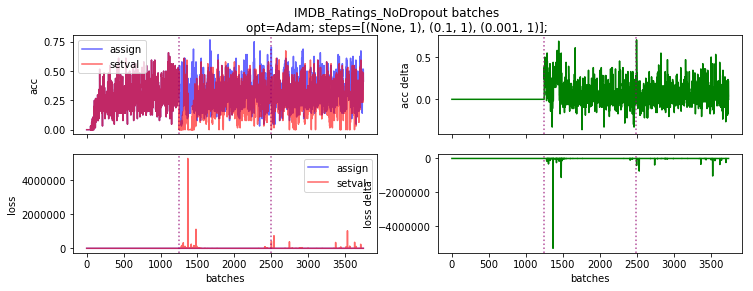

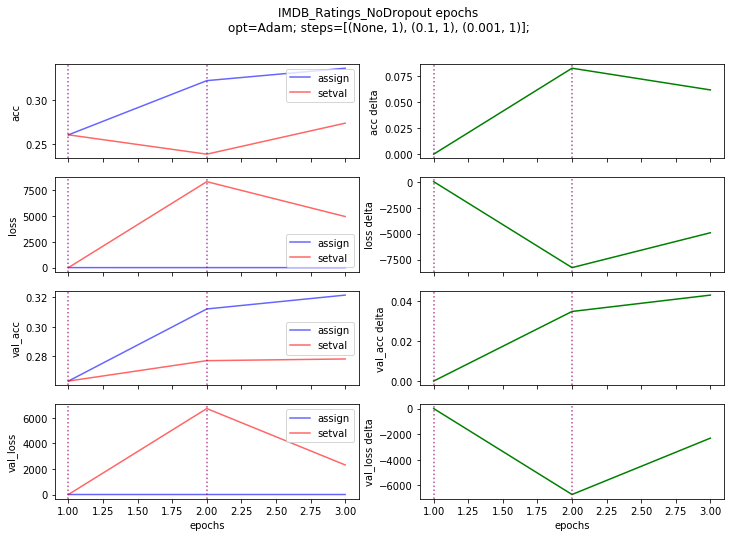

In [122]:
LRTester(IMDB_Ratings_NoDropout).run(steps=[None, 0.1, 0.001]).makefigs()

### CPU Results: IMDB Sentiment Analysis CNN

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 407s - loss: 0.5309 - acc: 0.9658 - val_loss: 7.4163 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 472s - loss: 0.9916 - acc: 0.4496 - val_loss: 7.9812 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 436s - loss: 0.4801 - acc: 0.9708 - val_loss: 8.0331 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 569s - loss: 4.5091 - acc: 0.5000 - val_loss: 1.1871 - val_acc: 0.5000


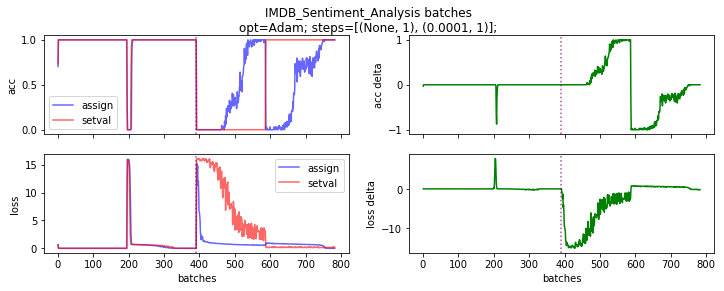

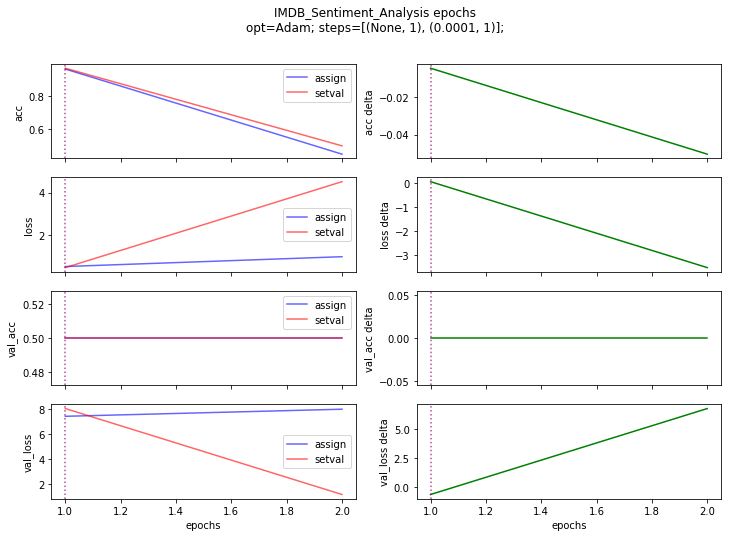

In [164]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=True)
LRTester(IMDB_Sentiment_Analysis).run(steps=[None, 1e-4], step_callback=step_callback).makefigs()

### CPU Results: IMDB Sentiment Analysis CNN (No Dropout)

### CPU Results: IMDB Sentiment Analysis Multi CNN

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 819s - loss: 7.9731 - acc: 0.4978 - val_loss: 7.9710 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 862s - loss: 7.9731 - acc: 0.4978 - val_loss: 7.9710 - val_acc: 0.5000


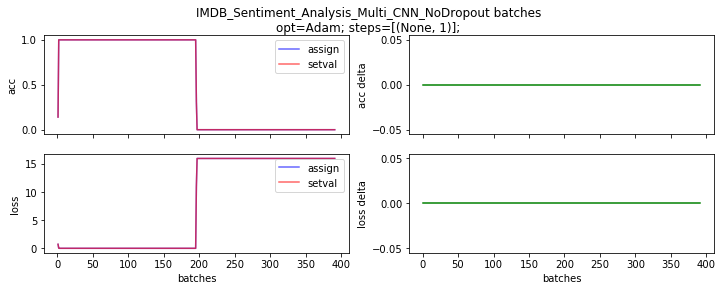

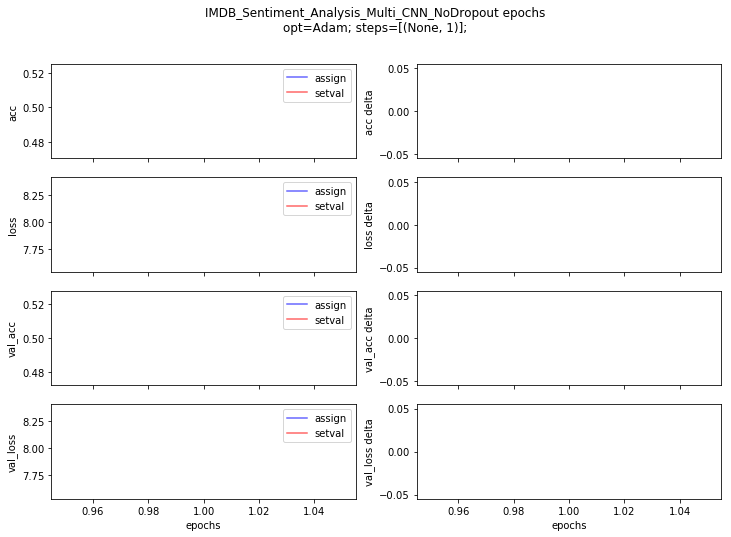

In [153]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=False)
LRTester(IMDB_Sentiment_Analysis_Multi_CNN).run(steps=[None, 1e-5], step_callback=step_callback).makefigs()

### CPU Results: IMDB Sentiment Analysis Multi CNN (No Dropout)

### CPU Results: Nietzsche 3-char model

Epoch 1/4
200297/200297 [==============================] - 49s - loss: 4.4180 - acc: 0.1032    
Epoch 2/4
200297/200297 [==============================] - 59s - loss: 4.3003 - acc: 0.1523    
Epoch 3/4
200297/200297 [==============================] - 71s - loss: 4.0547 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 79s - loss: 3.6775 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 86s - loss: 3.3536 - acc: 0.1524    
Epoch 2/4
200297/200297 [==============================] - 88s - loss: 3.2058 - acc: 0.1524    
Epoch 3/4
200297/200297 [==============================] - 52s - loss: 3.1462 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 84s - loss: 3.1189 - acc: 0.1524    - ETA: 0s - loss: 3.
Epoch 1/4
200297/200297 [==============================] - 84s - loss: 4.4180 - acc: 0.1032    
Epoch 2/4
200297/200297 [==============================] - 88s - loss: 4.3003 - acc: 0.1523    
Epoch 3/4
200297/200

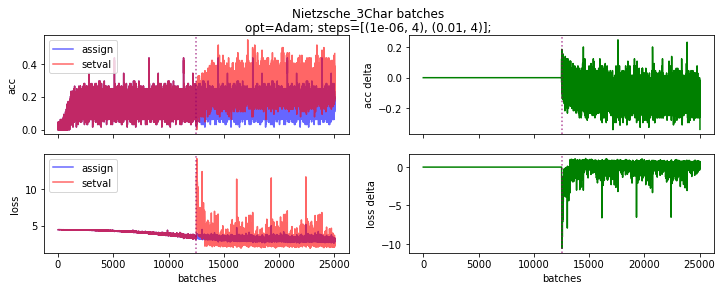

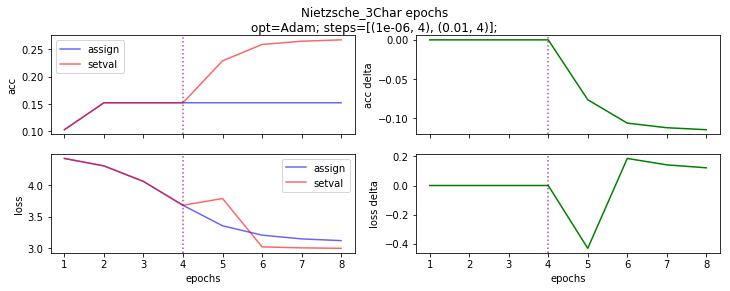

In [184]:
t = LRTester(Nietzsche_3Char).run(steps=[(0.000001, 4), (0.01, 4)]).makefigs()

In [191]:
nietzsche_compare_3char(t.models[0], t.models[1], inputs=['phi', ' th', ' an'])

[(' ', 'n'), (' ', 'e'), (' ', ' ')]

### CPU Results: Nietzsche RNN returing sequences

Epoch 1/4
75110/75110 [==============================] - 50s - loss: 2.4418 - acc: 0.3151    
Epoch 2/4
75110/75110 [==============================] - 50s - loss: 2.0191 - acc: 0.4092    
Epoch 3/4
75110/75110 [==============================] - 51s - loss: 1.8954 - acc: 0.4399    
Epoch 4/4
75110/75110 [==============================] - 56s - loss: 1.8315 - acc: 0.4559    
Epoch 1/4
75110/75110 [==============================] - 58s - loss: 1.7917 - acc: 0.4662    
Epoch 2/4
75110/75110 [==============================] - 64s - loss: 1.7636 - acc: 0.4730    
Epoch 3/4
75110/75110 [==============================] - 62s - loss: 1.7427 - acc: 0.4776    
Epoch 4/4
75110/75110 [==============================] - 68s - loss: 1.7264 - acc: 0.4816    
Epoch 1/4
75110/75110 [==============================] - 69s - loss: 2.4418 - acc: 0.3151    
Epoch 2/4
75110/75110 [==============================] - 71s - loss: 2.0191 - acc: 0.4092    
Epoch 3/4
75110/75110 [==============================] - 70s

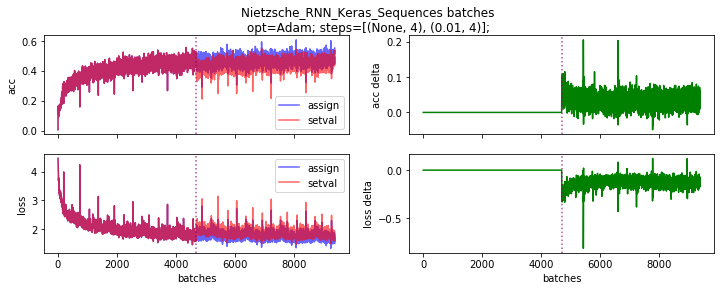

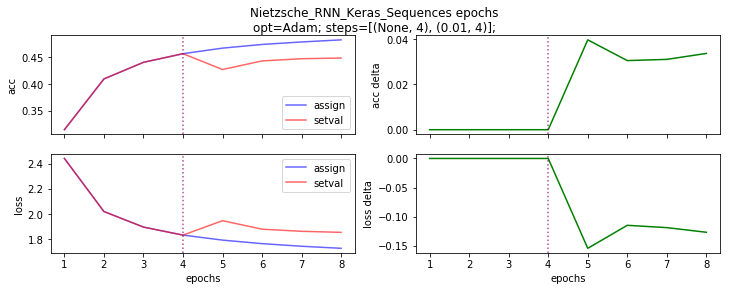

In [15]:
t = LRTester(Nietzsche_RNN_Keras_Sequences).run(steps=[(None, 4), (0.01, 4)]).makefigs()

In [16]:
nietzsche_get_nexts_keras(t.models[0], ' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


['t', 'h', 'e', 's', ' ', 's', 'n', ' ']

In [17]:
nietzsche_get_nexts_keras(t.models[1], ' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


['t', 'h', 'e', 's', ' ', 's', 'n', ' ']